In [1]:
import dropbox
import urllib.request, json 
from collections import defaultdict
from collections import OrderedDict
import datetime as DT
import ast
from __future__ import print_function
from __future__ import division
import collections
import nltk
import numpy as np
from string import punctuation
import csv
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

# Helper libraries
from w266_common import utils, vocabulary

########################### DLEE IMPORTS ##################################

# Import pandas and tensorflow
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1.10"))

# Import model
import models

# Import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import misc
from importlib import reload
import os, sys, re, json, time, datetime, shutil
import itertools
from w266_common import patched_numpy_io

/home/danlee85/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# ##Download the pre-processed tweets from dropbox

# access_token = 'p3Ze8FpdRTAAAAAAAAAADb9hCQ8aXXYU3A3gGM1HEXyeMrs8KI2SrA71KDmmCXte'
# dbx = dropbox.Dropbox(access_token)
# metadata, res = dbx.files_download(path="/Inputdata2.txt")


# access_token2 = 'm_fKi8mWZ0AAAAAAAAAADlfzTm37f1y45k92Xpiw1B6mjT3dQqzNvKgpIUSR17uq'
# dbx2 = dropbox.Dropbox(access_token2)

# #Write the combined file into the drive
# with open("InputX.txt", "wb") as f:
#     metadata, res = dbx.files_download(path="/Inputdata2.txt")
#     metadata2, res2 = dbx2.files_download(path="/Inputdata.txt")
#     f.write(res.content)
#     f.write(res2.content)

In [2]:
##Translate date of the tweet to quarter reference
def Quarterlookup(date):
    if date>=DT.datetime(2018,10,1):
        return '18Q4'
    elif date>=DT.datetime(2018,7,1):
        return '18Q3'
    elif date>=DT.datetime(2018,4,1):
        return '18Q2'
    elif date>=DT.datetime(2018,1,1):
        return '18Q1'
    elif date>=DT.datetime(2017,10,1):
        return '17Q4'
    elif date>=DT.datetime(2017,7,1):
        return '17Q3'
    elif date>=DT.datetime(2017,4,1):
        return '17Q2'
    elif date>=DT.datetime(2017,1,1):
        return '17Q1'
    elif date>=DT.datetime(2016,10,1):
        return '16Q4'
    elif date>=DT.datetime(2016,7,1):
        return '16Q3'
    elif date>=DT.datetime(2016,4,1):
        return '16Q2'
    elif date>=DT.datetime(2016,1,1):
        return '16Q1'
    elif date>=DT.datetime(2015,10,1):
        return '15Q4'
    elif date>=DT.datetime(2015,7,1):
        return '15Q3'
    elif date>=DT.datetime(2015,4,1):
        return '15Q2'
    else:
        return '15Q1'

In [3]:
##Reading the Input X file and process it
d=defaultdict(list)

with open('InputX.txt') as f:
    for line in f:
        count=0
        temp =-1
        k,v=line.split(':',1)
        while True:
            
            oldtemp=temp
            temp=v.find(']]',temp+1)
            if count==0:
                d[k].append(v[oldtemp+2:temp+2]) 
            else:
                d[k].append(v[oldtemp+4:temp+2])
           
             
            count+=1
            if temp == -1: break
#             if count == 500: break  # initially limit for time sake
    

In [4]:
#Read from the vocab file pre prepared
with open('vocab.csv', 'r') as f:
    reader = csv.reader(f,delimiter=';')
    allword = set(list(reader)[0])

In [5]:
allword=sorted(allword)
vocab = vocabulary.Vocabulary(allword, size=None)  # size=None means unlimited
print("Vocabulary size: {:,}".format(vocab.size))

Vocabulary size: 5,681


In [6]:
def pad_np_array(example_ids, max_len=50, pad_id=0):

    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    cpy_len = min(len(example_ids), max_len)

    arr = example_ids[:cpy_len]
    ns = cpy_len
    return arr, ns

In [7]:
#Dictionary to collect the tweet detail and the length of each tweet
InputX=defaultdict(dict)
InputN=defaultdict(dict)

In [8]:
#Set of all the stocks of interest
trainstock =['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger','WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty',"Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']

# trainstock =["Conn's"]

In [9]:
##Converting the string of data into dictionary


for key,value in d.items():
    Inputx=defaultdict(list)
    Inputn=defaultdict(list)
    if key in trainstock:
        for value2 in value:
        
            temp=value2.find('), ')
            date=value2[14:temp+3]
            try:
                year=int(date[1:5])
                month=int(date[date.find(',')+2:date.find(',',date.find(',')+1)])
                day=int(date[date.find(')')-2:date.find(')')])
            
                sentence, length = pad_np_array (vocab.words_to_ids(ast.literal_eval(value2[temp+3:-1])))
            
                Inputx[Quarterlookup(DT.datetime(year,month,day))].append(sentence)
                Inputn[Quarterlookup(DT.datetime(year,month,day))].append(length)
            except:
                pass

    InputX[key]=OrderedDict(sorted(Inputx.items()))
    InputN[key]=OrderedDict(sorted(Inputn.items()))

In [10]:
##List of stockname and relevant stock code
l = [("CVSHealth", "CVS"),
("RiteAid", "RAD"),
("Conn's", "CONN"),
("Casey's", "CASY"),
("Kroger", "KR"),
("WeisMarkets", "WMK"),
("HavertyFurniture", "HVT"),
("Kirkland's", "KIRK"),
("Pier1Imports","PIR"),
("BuildersFirstSource","BLDR"),
("HuttigBuildingProducts", "HBP"),
("LumberLiquidators", "LL"),
("TransWorldEntertainment", "TWMC"),
("MarineMax", "HZO"),
("Medifast", "MED"),
("SallyBeauty", "SBH"),
("Sotheby's", "BID"),
("StarGasPartners", "SGU"),
("SuburbanPropanePartners", "SPH"),
("TitanMachinery", "TITN"),
("TractorSupply","TSCO"),
("TravelCentersofAmerica", "TA"),
("Big5SportingGoods", "BGFV"),
("Dick'sSportingGoods", "DKS"),
("HibbettSports", "HIBB"),
("Build-A-BearWorkshop", "BBW")]
     
all_stock = {}
[all_stock.update({k:v}) for k,v in l]
print(all_stock)

{'CVSHealth': 'CVS', 'RiteAid': 'RAD', "Conn's": 'CONN', "Casey's": 'CASY', 'Kroger': 'KR', 'WeisMarkets': 'WMK', 'HavertyFurniture': 'HVT', "Kirkland's": 'KIRK', 'Pier1Imports': 'PIR', 'BuildersFirstSource': 'BLDR', 'HuttigBuildingProducts': 'HBP', 'LumberLiquidators': 'LL', 'TransWorldEntertainment': 'TWMC', 'MarineMax': 'HZO', 'Medifast': 'MED', 'SallyBeauty': 'SBH', "Sotheby's": 'BID', 'StarGasPartners': 'SGU', 'SuburbanPropanePartners': 'SPH', 'TitanMachinery': 'TITN', 'TractorSupply': 'TSCO', 'TravelCentersofAmerica': 'TA', 'Big5SportingGoods': 'BGFV', "Dick'sSportingGoods": 'DKS', 'HibbettSports': 'HIBB', 'Build-A-BearWorkshop': 'BBW'}


In [11]:
##Read the quarterly return detail from edgaronline and convert into library
top="http://datafied.api.edgar-online.com/v2/corefinancials/qtr?primarysymbols="
bottom="&appkey=asc97xrhkyu4959aptu76zxj"
Outputy =defaultdict(dict)
for stockname,stock in all_stock.items():
    check=top+stock+bottom
    with urllib.request.urlopen(check) as url:
        data = json.loads(url.read().decode())
    count1=0
    count2=0
    end_date=[]
    revenue_change=[]
    last_rev=0

    for key, value in data.items():
        
        for key2, value2 in value.items():          
        
            if count1!=0:  
                for i in reversed(value2):
                  
                    for j in i["values"]:
                     
                        if count2!=0:   
                            if j["field"] =="periodenddate":
                                end_date.append(Quarterlookup(DT.datetime.strptime(j['value'], '%m/%d/%Y')))
                       
                            ##Convert revenue into the y_label of 0 for negative growth and 1 for positive growth
                            if j["field"] =="totalrevenue":
                                revenue_cal =round(float(j['value'])/float(last_rev) - 1,3)
                                if revenue_cal>0:
                                    revenue_change.append(1)
                                else:
                                    revenue_change.append(0)
                        else:
                            
                            if j["field"] =="totalrevenue":      
                                last_rev=j['value']
                              
                    count2+=1
            count1+=1
            
    ##Output will be a dictionary with stockname
    Outputy[stockname]["period"]=end_date
    Outputy[stockname]["revenuechange"]=revenue_change

In [13]:
y_keys = list(Outputy.keys())
print(y_keys)

['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger', 'WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty', "Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']


In [14]:
print(Outputy[y_keys[0]])

{'period': ['15Q1', '15Q2', '15Q3', '15Q4', '16Q1', '16Q2', '16Q3', '16Q4', '17Q1', '17Q2', '17Q3', '17Q4', '18Q1', '18Q2', '18Q3'], 'revenuechange': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
with open('Outputy.txt', 'w') as f:
    print(Outputy, file=f)

In [16]:
train_x_init = []
train_n_init = []
train_y_init = []
dev_x_init = []
dev_n_init = []
dev_y_init = []
test_x_init = []
test_n_init = []
test_y_init = []


In [17]:
trainquarter=['15Q1','15Q2','15Q3','15Q4','16Q1','16Q2','16Q3','16Q4','17Q1','17Q2','17Q3','17Q4','18Q1']

for i in trainstock:
    for j in range(len(trainquarter)):
        try:
                train_x_init.append(InputX [i][trainquarter[j]])
                train_n_init.append(InputN [i][trainquarter[j]])
                length=len(InputN [i][trainquarter[j]])           
                train_y_init.append([Outputy [i]['revenuechange'][j]]*length)
      
        except:
            pass



In [18]:
teststock =['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger','WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty',"Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']
# teststock =["Conn's"]
testquarter=['18Q2','18Q3']

for i in teststock:
    for j in range(len(testquarter)):
        try:
            if testquarter[j]=='18Q3':
                test_x_init.append(InputX [i][testquarter[j]])
                test_n_init.append(InputN [i][testquarter[j]])
                length=len(InputN [i][testquarter[j]])
                test_y_init.append([Outputy [i]['revenuechange'][j]]*length)   
            
            elif testquarter[j]=='18Q2':
                dev_x_init.append(InputX [i][testquarter[j]])
                dev_n_init.append(InputN [i][testquarter[j]])
                length=len(InputN [i][testquarter[j]])
                dev_y_init.append([Outputy [i]['revenuechange'][j]]*length)     
               
      
        except:
            pass

In [19]:

train_x_init2 = []
train_n_init2 = []
train_y_init2 = []
dev_x_init2 = []
dev_n_init2 = []
dev_y_init2 = []
test_x_init2 = []
test_n_init2 = []
test_y_init2 = []

for i in range(len(train_x_init)):
    for j in range(len(train_x_init[i])):
        train_x_init2.append(train_x_init[i][j])
        train_n_init2.append(train_n_init[i][j])
        train_y_init2.append(train_y_init[i][j])
        
for i in range(len(dev_x_init)):
    for j in range(len(dev_x_init[i])):
        dev_x_init2.append(dev_x_init[i][j])
        dev_n_init2.append(dev_n_init[i][j])
        dev_y_init2.append(dev_y_init[i][j])
        
for i in range(len(test_x_init)):
    for j in range(len(test_x_init[i])):
        test_x_init2.append(test_x_init[i][j])
        test_n_init2.append(test_n_init[i][j])
        test_y_init2.append(test_y_init[i][j])



# NEURAL BAG OF WORDS MODEL #

In [20]:
for i in range(10):

    print(train_x_init2[i])
    print(test_x_init2[i])
    print(dev_x_init2[i])


[1478, 5673, 4936, 3188, 5177, 802, 2, 1741, 5394, 403, 997, 3098, 3445, 3437, 2, 1299, 2, 503, 2, 804, 3455, 1349, 162, 483, 2245, 1448, 5006, 2017, 3437, 2, 2251, 5534, 3515, 2548, 2865, 2868, 3228, 2, 2386, 2, 64, 803, 2]
[1902, 4889, 5406, 403, 1295, 3528, 3482, 4465, 2, 1295, 2, 2, 1299, 2, 2, 2053, 2, 2, 3294, 2, 2, 3349, 2, 2, 3419, 2, 2, 3483, 2, 2, 3546, 2, 2, 4186, 2, 2, 4465, 2, 2, 5406, 2, 2, 5442, 2386, 2, 64, 1854, 353, 5678]
[161, 5592, 3437, 4581, 3615, 3455, 5015, 3613, 5100, 654, 2250, 1478, 5673, 4936, 1939, 5100, 4542, 5006, 3614, 2, 1299, 2, 1301, 5669, 949, 5548, 417]
[161, 5592, 3437, 4581, 3615, 3455, 5015, 3613, 5100, 654, 2250, 1478, 5673, 4936, 1939, 5100, 4542, 5006, 3614, 2, 1299, 2, 1301, 5669, 949, 5548, 417]
[1478, 5673, 4936, 3188, 5177, 802, 2, 1741, 5394, 403, 997, 3098, 3445, 3437, 2, 1299, 2, 503, 2, 804, 3455, 1349, 162, 483, 2245, 1448, 5006, 2017, 3437, 2, 2251, 5534, 3515, 2548, 2865, 2868, 3228, 2, 2386, 2, 64, 803, 2]
[4659, 5006, 2, 309, 2, 1

In [21]:
def pad_np_array2(example_ids, max_len=50, pad_id=0):

    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr ##I HAD TO REMOVE NS TO MAKE IT WORK< PLEASE TAKE A LOOK IF IT HAS ANY IMPACT

In [22]:
train_x = pad_np_array2(train_x_init2, max_len = 50, pad_id=0)
train_n = np.array(train_n_init2)
train_y = np.array(train_y_init2)

test_x = pad_np_array2(test_x_init2, max_len = 50, pad_id=0)
test_n = np.array(test_n_init2)
test_y = np.array(test_y_init2)

dev_x = pad_np_array2(dev_x_init2, max_len = 50, pad_id=0)
dev_n = np.array(dev_n_init2)
dev_y = np.array(dev_y_init2)

In [29]:
print(len(train_x))
print(len(train_n))
print(len(train_y))
print(len(test_x))
print(len(test_n))
print(len(test_y))

6692652
6692652
6692652
518456
518456
518456


[(0, 292501), (1, 225955)]
[0 1]
[292501 225955]


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([225955. , 232609.6, 239264.2, 245918.8, 252573.4, 259228. ,
        265882.6, 272537.2, 279191.8, 285846.4, 292501. ]),
 <a list of 10 Patch objects>)

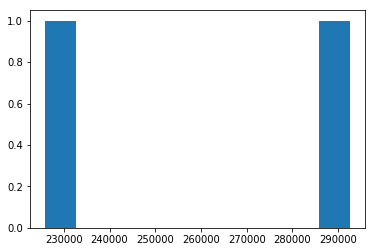

In [28]:
lbl, cnts = np.unique(test_y, return_counts=True)
print(list(zip(lbl, cnts)))
print(lbl)
print(cnts)

# labels = 
# counts = 

plt.hist(cnts)

[(0, 3461962), (1, 3230690)]
[0 1]
[3461962 3230690]


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([3230690. , 3253817.2, 3276944.4, 3300071.6, 3323198.8, 3346326. ,
        3369453.2, 3392580.4, 3415707.6, 3438834.8, 3461962. ]),
 <a list of 10 Patch objects>)

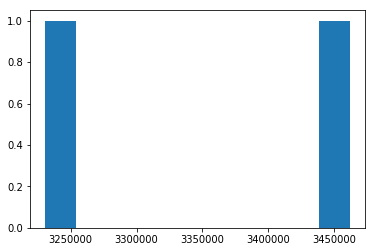

In [36]:
lbl, cnts = np.unique(train_y, return_counts=True)
print(list(zip(lbl, cnts)))
print(lbl)
print(cnts)

# labels = 
# counts = 

plt.hist(cnts)

In [24]:
reload(models)

x, ns, y = train_x, train_n, train_y
batch_size = 125

# Specify model hyperparameters as used by model_fn
model_params = dict(V=vocab.size, embed_dim=50, hidden_dims=[25], num_classes=2,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)
model_fn = models.classifier_model_fn

total_batches = 0
total_examples = 0
total_loss = 0
loss_ema = np.log(2)  # track exponential-moving-average of loss
ema_decay = np.exp(-1/10)  # decay parameter for moving average = np.exp(-1/history_length)
with tf.Graph().as_default(), tf.Session() as sess:
    ##
    # Construct the graph here. No session.run calls - just wiring up Tensors.
    ##
    # Add placeholders so we can feed in data.
    x_ph_  = tf.placeholder(tf.int32, shape=[None, x.shape[1]])  # [batch_size, max_len]
    ns_ph_ = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    y_ph_  = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    
    # Construct the graph using model_fn
    features = {"ids": x_ph_, "ns": ns_ph_}  # note that values are Tensors
    estimator_spec = model_fn(features, labels=y_ph_, mode=tf.estimator.ModeKeys.TRAIN,
                              params=model_params)
    loss_     = estimator_spec.loss
    train_op_ = estimator_spec.train_op
    
    ##
    # Done constructing the graph, now we can make session.run calls.
    ##
    sess.run(tf.global_variables_initializer())
    
    # Run a single epoch
    t0 = time.time()
    for (bx, bns, by) in utils.multi_batch_generator(batch_size, x, ns, y):
        # feed NumPy arrays into the placeholder Tensors
        feed_dict = {x_ph_: bx, ns_ph_: bns, y_ph_: by}
        batch_loss, _ = sess.run([loss_, train_op_], feed_dict=feed_dict)
        
        # Compute some statistics
        total_batches += 1
        total_examples += len(bx)
        total_loss += batch_loss * len(bx)  # re-scale, since batch loss is mean
        # Compute moving average to smooth out noisy per-batch loss
        loss_ema = ema_decay * loss_ema + (1 - ema_decay) * batch_loss
        
        if (total_batches % 125 == 0):
            print("{:5,} examples, moving-average loss {:.2f}".format(total_examples, 
                                                                      loss_ema))    
    print("Completed one epoch in {:s}".format(utils.pretty_timedelta(since=t0)))

15,625 examples, moving-average loss 0.24
31,250 examples, moving-average loss 0.17
46,875 examples, moving-average loss 0.14
62,500 examples, moving-average loss 0.11
78,125 examples, moving-average loss 0.12
93,750 examples, moving-average loss 0.09
109,375 examples, moving-average loss 0.08
125,000 examples, moving-average loss 0.10
140,625 examples, moving-average loss 0.08
156,250 examples, moving-average loss 0.07
171,875 examples, moving-average loss 0.10
187,500 examples, moving-average loss 0.08
203,125 examples, moving-average loss 0.07
218,750 examples, moving-average loss 0.07
234,375 examples, moving-average loss 0.06
250,000 examples, moving-average loss 0.06
265,625 examples, moving-average loss 0.22
281,250 examples, moving-average loss 0.09
296,875 examples, moving-average loss 0.07
312,500 examples, moving-average loss 0.08
328,125 examples, moving-average loss 0.07
343,750 examples, moving-average loss 0.07
359,375 examples, moving-average loss 0.06
375,000 examples,

2,906,250 examples, moving-average loss 0.05
2,921,875 examples, moving-average loss 0.05
2,937,500 examples, moving-average loss 0.05
2,953,125 examples, moving-average loss 0.05
2,968,750 examples, moving-average loss 0.05
2,984,375 examples, moving-average loss 0.05
3,000,000 examples, moving-average loss 0.05
3,015,625 examples, moving-average loss 0.05
3,031,250 examples, moving-average loss 0.04
3,046,875 examples, moving-average loss 0.04
3,062,500 examples, moving-average loss 0.04
3,078,125 examples, moving-average loss 0.04
3,093,750 examples, moving-average loss 0.04
3,109,375 examples, moving-average loss 0.04
3,125,000 examples, moving-average loss 0.04
3,140,625 examples, moving-average loss 0.04
3,156,250 examples, moving-average loss 0.04
3,171,875 examples, moving-average loss 0.04
3,187,500 examples, moving-average loss 0.04
3,203,125 examples, moving-average loss 0.04
3,218,750 examples, moving-average loss 0.04
3,234,375 examples, moving-average loss 0.36
3,250,000 

5,765,625 examples, moving-average loss 0.07
5,781,250 examples, moving-average loss 0.07
5,796,875 examples, moving-average loss 0.15
5,812,500 examples, moving-average loss 0.06
5,828,125 examples, moving-average loss 0.07
5,843,750 examples, moving-average loss 0.07
5,859,375 examples, moving-average loss 0.06
5,875,000 examples, moving-average loss 0.06
5,890,625 examples, moving-average loss 0.06
5,906,250 examples, moving-average loss 0.06
5,921,875 examples, moving-average loss 0.06
5,937,500 examples, moving-average loss 0.06
5,953,125 examples, moving-average loss 0.05
5,968,750 examples, moving-average loss 0.10
5,984,375 examples, moving-average loss 0.19
6,000,000 examples, moving-average loss 0.06
6,015,625 examples, moving-average loss 0.06
6,031,250 examples, moving-average loss 0.06
6,046,875 examples, moving-average loss 0.05
6,062,500 examples, moving-average loss 0.15
6,078,125 examples, moving-average loss 0.09
6,093,750 examples, moving-average loss 0.06
6,109,375 

In [30]:
import models; reload(models)

# Specify model hyperparameters as used by model_fn
model_params = dict(V=vocab.size, embed_dim=50, hidden_dims=[25], num_classes=2,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)

checkpoint_dir = "/tmp/tf_bow_sst_" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
# Write vocabulary to file, so TensorBoard can label embeddings.
# creates checkpoint_dir/projector_config.pbtxt and checkpoint_dir/metadata.tsv
vocab.write_projector_config(checkpoint_dir, "Encoder/Embedding_Layer/W_embed")

model = tf.estimator.Estimator(model_fn=models.classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)
print("")
print("To view training (once it starts), run:\n")
print("    tensorboard --logdir='{:s}' --port 6006".format(checkpoint_dir))
print("\nThen in your browser, open: http://localhost:6006")

Vocabulary (5,681 words) written to '/tmp/tf_bow_sst_20181203-0647/metadata.tsv'
Projector config written to /tmp/tf_bow_sst_20181203-0647/projector_config.pbtxt
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_bow_sst_20181203-0647', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5a08cef8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

To view training (once it starts), run:

    tensorboard --logdir='/tmp/tf_bow_sst_20181203-0647' --port 6006

Then in your browser, open: http:

In [31]:
# Training params, just used in this cell for the input_fn-s
train_params = dict(batch_size=125, total_epochs=10, eval_every=2)
assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

# Construct and train the model, saving checkpoints to the directory above.
# Input function for training set batches
# Do 'eval_every' epochs at once, followed by evaluating on the dev set.
# NOTE: use patch_numpy_io.numpy_input_fn instead of tf.estimator.inputs.numpy_input_fn
train_input_fn = patched_numpy_io.numpy_input_fn(
                    x={"ids": train_x, "ns": train_n}, y=train_y,
                    batch_size=train_params['batch_size'], 
                    num_epochs=train_params['eval_every'], shuffle=True, seed=42
                 )

# Input function for dev set batches. As above, but:
# - Don't randomize order
# - Iterate exactly once (one epoch)
dev_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": dev_x, "ns": dev_n}, y=dev_y,
                    batch_size=125, num_epochs=1, shuffle=False
                )

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    # Train for a few epochs, then evaluate on dev
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tf_bow_sst_20181203-0647/model.ckpt.
INFO:tensorflow:loss = 1.1981654, step = 1
INFO:tensorflow:global_step/sec: 179.693
INFO:tensorflow:loss = 0.29255074, step = 101 (0.558 sec)
INFO:tensorflow:global_step/sec: 188.007
INFO:tensorflow:loss = 0.1780093, step = 201 (0.531 sec)
INFO:tensorflow:global_step/sec: 198.003
INFO:tensorflow:loss = 0.11718589, step = 301 (0.506 sec)
INFO:tensorflow:global_step/sec: 194.026
INFO:tensorflow:loss = 0.08330337, step = 401 (0.515 sec)
INFO:tensorflow:global_step/sec: 209.848
INFO:tensorflow:loss = 0.06454619, step = 501 (0.476 sec)
INFO:tensorflow:global_step/sec: 213.945
INFO:tensorflow:loss = 0.053788833, step = 601 (0.468 sec)
INFO:tensorflow:global_step/sec: 214.2

INFO:tensorflow:loss = 0.059156194, step = 7901 (0.499 sec)
INFO:tensorflow:global_step/sec: 214.389
INFO:tensorflow:loss = 0.088102005, step = 8001 (0.467 sec)
INFO:tensorflow:global_step/sec: 206.843
INFO:tensorflow:loss = 0.072569564, step = 8101 (0.483 sec)
INFO:tensorflow:global_step/sec: 204.732
INFO:tensorflow:loss = 0.064950004, step = 8201 (0.488 sec)
INFO:tensorflow:global_step/sec: 212.408
INFO:tensorflow:loss = 0.061868515, step = 8301 (0.471 sec)
INFO:tensorflow:global_step/sec: 210.917
INFO:tensorflow:loss = 0.05945771, step = 8401 (0.474 sec)
INFO:tensorflow:global_step/sec: 211.907
INFO:tensorflow:loss = 0.05788524, step = 8501 (0.472 sec)
INFO:tensorflow:global_step/sec: 209.523
INFO:tensorflow:loss = 0.08559945, step = 8601 (0.477 sec)
INFO:tensorflow:global_step/sec: 211.54
INFO:tensorflow:loss = 0.070651196, step = 8701 (0.474 sec)
INFO:tensorflow:global_step/sec: 208.81
INFO:tensorflow:loss = 0.06722339, step = 8801 (0.478 sec)
INFO:tensorflow:global_step/sec: 212.

INFO:tensorflow:global_step/sec: 217.293
INFO:tensorflow:loss = 0.08025493, step = 16101 (0.460 sec)
INFO:tensorflow:global_step/sec: 217.777
INFO:tensorflow:loss = 0.06792408, step = 16201 (0.460 sec)
INFO:tensorflow:global_step/sec: 207.307
INFO:tensorflow:loss = 0.08500758, step = 16301 (0.482 sec)
INFO:tensorflow:global_step/sec: 220.67
INFO:tensorflow:loss = 0.07340373, step = 16401 (0.453 sec)
INFO:tensorflow:global_step/sec: 212.535
INFO:tensorflow:loss = 0.07007583, step = 16501 (0.471 sec)
INFO:tensorflow:global_step/sec: 209.049
INFO:tensorflow:loss = 0.068179324, step = 16601 (0.478 sec)
INFO:tensorflow:global_step/sec: 213.978
INFO:tensorflow:loss = 0.07193518, step = 16701 (0.467 sec)
INFO:tensorflow:global_step/sec: 212.49
INFO:tensorflow:loss = 0.07627863, step = 16801 (0.471 sec)
INFO:tensorflow:global_step/sec: 204.888
INFO:tensorflow:loss = 0.06666041, step = 16901 (0.488 sec)
INFO:tensorflow:global_step/sec: 190.71
INFO:tensorflow:loss = 0.06313853, step = 17001 (0.5

INFO:tensorflow:global_step/sec: 213.829
INFO:tensorflow:loss = 0.060742393, step = 24201 (0.468 sec)
INFO:tensorflow:global_step/sec: 214.411
INFO:tensorflow:loss = 0.059264887, step = 24301 (0.466 sec)
INFO:tensorflow:global_step/sec: 211.143
INFO:tensorflow:loss = 0.057340413, step = 24401 (0.474 sec)
INFO:tensorflow:global_step/sec: 203.093
INFO:tensorflow:loss = 0.056968957, step = 24501 (0.493 sec)
INFO:tensorflow:global_step/sec: 212.492
INFO:tensorflow:loss = 0.055296686, step = 24601 (0.471 sec)
INFO:tensorflow:global_step/sec: 216.389
INFO:tensorflow:loss = 0.05430362, step = 24701 (0.462 sec)
INFO:tensorflow:global_step/sec: 217.317
INFO:tensorflow:loss = 0.052640684, step = 24801 (0.461 sec)
INFO:tensorflow:global_step/sec: 212.212
INFO:tensorflow:loss = 0.051511593, step = 24901 (0.471 sec)
INFO:tensorflow:global_step/sec: 213.881
INFO:tensorflow:loss = 0.050591182, step = 25001 (0.468 sec)
INFO:tensorflow:global_step/sec: 212.716
INFO:tensorflow:loss = 0.049937397, step =

INFO:tensorflow:global_step/sec: 213.331
INFO:tensorflow:loss = 0.065945186, step = 32301 (0.469 sec)
INFO:tensorflow:global_step/sec: 208.508
INFO:tensorflow:loss = 0.06253396, step = 32401 (0.480 sec)
INFO:tensorflow:global_step/sec: 216.92
INFO:tensorflow:loss = 0.060860902, step = 32501 (0.460 sec)
INFO:tensorflow:global_step/sec: 221.183
INFO:tensorflow:loss = 0.13130787, step = 32601 (0.452 sec)
INFO:tensorflow:global_step/sec: 215.873
INFO:tensorflow:loss = 0.07826014, step = 32701 (0.464 sec)
INFO:tensorflow:global_step/sec: 215.084
INFO:tensorflow:loss = 0.075065665, step = 32801 (0.465 sec)
INFO:tensorflow:global_step/sec: 215.569
INFO:tensorflow:loss = 0.070973165, step = 32901 (0.464 sec)
INFO:tensorflow:global_step/sec: 214.169
INFO:tensorflow:loss = 0.06981928, step = 33001 (0.467 sec)
INFO:tensorflow:global_step/sec: 220.565
INFO:tensorflow:loss = 0.06737996, step = 33101 (0.454 sec)
INFO:tensorflow:global_step/sec: 221.415
INFO:tensorflow:loss = 0.06456935, step = 33201

INFO:tensorflow:global_step/sec: 219.482
INFO:tensorflow:loss = 0.04188215, step = 40401 (0.455 sec)
INFO:tensorflow:global_step/sec: 213.608
INFO:tensorflow:loss = 0.11573124, step = 40501 (0.468 sec)
INFO:tensorflow:global_step/sec: 216.805
INFO:tensorflow:loss = 0.091202, step = 40601 (0.462 sec)
INFO:tensorflow:global_step/sec: 216.291
INFO:tensorflow:loss = 0.085470796, step = 40701 (0.462 sec)
INFO:tensorflow:global_step/sec: 213.673
INFO:tensorflow:loss = 0.08277493, step = 40801 (0.468 sec)
INFO:tensorflow:global_step/sec: 211.671
INFO:tensorflow:loss = 0.080995865, step = 40901 (0.472 sec)
INFO:tensorflow:global_step/sec: 209.965
INFO:tensorflow:loss = 0.0767952, step = 41001 (0.476 sec)
INFO:tensorflow:global_step/sec: 216.782
INFO:tensorflow:loss = 0.075124055, step = 41101 (0.462 sec)
INFO:tensorflow:global_step/sec: 208.982
INFO:tensorflow:loss = 0.07194589, step = 41201 (0.478 sec)
INFO:tensorflow:global_step/sec: 215.756
INFO:tensorflow:loss = 0.06981384, step = 41301 (0

INFO:tensorflow:loss = 0.05029476, step = 48501 (0.471 sec)
INFO:tensorflow:global_step/sec: 208.562
INFO:tensorflow:loss = 0.04936835, step = 48601 (0.476 sec)
INFO:tensorflow:global_step/sec: 215.366
INFO:tensorflow:loss = 0.049225867, step = 48701 (0.464 sec)
INFO:tensorflow:global_step/sec: 221.11
INFO:tensorflow:loss = 0.047864433, step = 48801 (0.452 sec)
INFO:tensorflow:global_step/sec: 216.735
INFO:tensorflow:loss = 0.048181914, step = 48901 (0.462 sec)
INFO:tensorflow:global_step/sec: 206.109
INFO:tensorflow:loss = 0.047855046, step = 49001 (0.485 sec)
INFO:tensorflow:global_step/sec: 217.141
INFO:tensorflow:loss = 0.047751058, step = 49101 (0.461 sec)
INFO:tensorflow:global_step/sec: 213.577
INFO:tensorflow:loss = 0.047112644, step = 49201 (0.470 sec)
INFO:tensorflow:global_step/sec: 216.985
INFO:tensorflow:loss = 0.046399254, step = 49301 (0.459 sec)
INFO:tensorflow:global_step/sec: 210.309
INFO:tensorflow:loss = 0.04578745, step = 49401 (0.476 sec)
INFO:tensorflow:global_st

INFO:tensorflow:loss = 0.07235559, step = 56601 (0.516 sec)
INFO:tensorflow:global_step/sec: 204.358
INFO:tensorflow:loss = 0.068578325, step = 56701 (0.489 sec)
INFO:tensorflow:global_step/sec: 209.705
INFO:tensorflow:loss = 0.06667599, step = 56801 (0.477 sec)
INFO:tensorflow:global_step/sec: 198.533
INFO:tensorflow:loss = 0.066369966, step = 56901 (0.504 sec)
INFO:tensorflow:global_step/sec: 208.356
INFO:tensorflow:loss = 0.2713495, step = 57001 (0.480 sec)
INFO:tensorflow:global_step/sec: 205.658
INFO:tensorflow:loss = 0.057035476, step = 57101 (0.486 sec)
INFO:tensorflow:global_step/sec: 205.379
INFO:tensorflow:loss = 0.073526494, step = 57201 (0.487 sec)
INFO:tensorflow:global_step/sec: 203.534
INFO:tensorflow:loss = 0.06452691, step = 57301 (0.491 sec)
INFO:tensorflow:global_step/sec: 205.876
INFO:tensorflow:loss = 0.060539827, step = 57401 (0.486 sec)
INFO:tensorflow:global_step/sec: 204.347
INFO:tensorflow:loss = 0.056464225, step = 57501 (0.489 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.43483728, step = 64701 (0.465 sec)
INFO:tensorflow:global_step/sec: 206.404
INFO:tensorflow:loss = 0.07505837, step = 64801 (0.484 sec)
INFO:tensorflow:global_step/sec: 208.367
INFO:tensorflow:loss = 0.072016865, step = 64901 (0.480 sec)
INFO:tensorflow:global_step/sec: 210.494
INFO:tensorflow:loss = 0.063732445, step = 65001 (0.475 sec)
INFO:tensorflow:global_step/sec: 216.691
INFO:tensorflow:loss = 0.5624226, step = 65101 (0.461 sec)
INFO:tensorflow:global_step/sec: 208.389
INFO:tensorflow:loss = 0.076508544, step = 65201 (0.480 sec)
INFO:tensorflow:global_step/sec: 200.163
INFO:tensorflow:loss = 0.069272354, step = 65301 (0.500 sec)
INFO:tensorflow:global_step/sec: 210.779
INFO:tensorflow:loss = 0.06245211, step = 65401 (0.474 sec)
INFO:tensorflow:global_step/sec: 201.333
INFO:tensorflow:loss = 0.32803226, step = 65501 (0.497 sec)
INFO:tensorflow:global_step/sec: 210.1
INFO:tensorflow:loss = 0.07161149, step = 65601 (0.476 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:global_step/sec: 213.335
INFO:tensorflow:loss = 0.2529667, step = 72901 (0.469 sec)
INFO:tensorflow:global_step/sec: 218.749
INFO:tensorflow:loss = 0.097070694, step = 73001 (0.457 sec)
INFO:tensorflow:global_step/sec: 216.906
INFO:tensorflow:loss = 0.108719856, step = 73101 (0.461 sec)
INFO:tensorflow:global_step/sec: 207.632
INFO:tensorflow:loss = 0.06584786, step = 73201 (0.481 sec)
INFO:tensorflow:global_step/sec: 206.83
INFO:tensorflow:loss = 0.065186754, step = 73301 (0.484 sec)
INFO:tensorflow:global_step/sec: 211.085
INFO:tensorflow:loss = 0.05702228, step = 73401 (0.474 sec)
INFO:tensorflow:global_step/sec: 210.509
INFO:tensorflow:loss = 0.057057407, step = 73501 (0.475 sec)
INFO:tensorflow:global_step/sec: 208.972
INFO:tensorflow:loss = 0.053873647, step = 73601 (0.479 sec)
INFO:tensorflow:global_step/sec: 216.821
INFO:tensorflow:loss = 0.053990502, step = 73701 (0.461 sec)
INFO:tensorflow:global_step/sec: 208.659
INFO:tensorflow:loss = 0.11734568, step = 7380

INFO:tensorflow:global_step/sec: 207.907
INFO:tensorflow:loss = 0.04432638, step = 81001 (0.481 sec)
INFO:tensorflow:global_step/sec: 215.755
INFO:tensorflow:loss = 0.044077307, step = 81101 (0.464 sec)
INFO:tensorflow:global_step/sec: 218.329
INFO:tensorflow:loss = 0.043730523, step = 81201 (0.458 sec)
INFO:tensorflow:global_step/sec: 219.461
INFO:tensorflow:loss = 0.043380767, step = 81301 (0.461 sec)
INFO:tensorflow:global_step/sec: 207.445
INFO:tensorflow:loss = 0.043043695, step = 81401 (0.477 sec)
INFO:tensorflow:global_step/sec: 219.237
INFO:tensorflow:loss = 0.04273457, step = 81501 (0.456 sec)
INFO:tensorflow:global_step/sec: 212.931
INFO:tensorflow:loss = 0.042624712, step = 81601 (0.469 sec)
INFO:tensorflow:global_step/sec: 212.44
INFO:tensorflow:loss = 0.04219388, step = 81701 (0.473 sec)
INFO:tensorflow:global_step/sec: 209.928
INFO:tensorflow:loss = 0.041950956, step = 81801 (0.475 sec)
INFO:tensorflow:global_step/sec: 217.709
INFO:tensorflow:loss = 0.041814536, step = 81

INFO:tensorflow:global_step/sec: 210.186
INFO:tensorflow:loss = 0.04598145, step = 89101 (0.475 sec)
INFO:tensorflow:global_step/sec: 211.036
INFO:tensorflow:loss = 0.045896452, step = 89201 (0.474 sec)
INFO:tensorflow:global_step/sec: 215.301
INFO:tensorflow:loss = 0.045403976, step = 89301 (0.465 sec)
INFO:tensorflow:global_step/sec: 208.882
INFO:tensorflow:loss = 0.045257412, step = 89401 (0.478 sec)
INFO:tensorflow:global_step/sec: 213.927
INFO:tensorflow:loss = 0.04492244, step = 89501 (0.468 sec)
INFO:tensorflow:global_step/sec: 213.722
INFO:tensorflow:loss = 0.04508221, step = 89601 (0.468 sec)
INFO:tensorflow:global_step/sec: 209.166
INFO:tensorflow:loss = 0.044697814, step = 89701 (0.478 sec)
INFO:tensorflow:global_step/sec: 214.493
INFO:tensorflow:loss = 0.04348519, step = 89801 (0.467 sec)
INFO:tensorflow:global_step/sec: 212.664
INFO:tensorflow:loss = 0.043214947, step = 89901 (0.470 sec)
INFO:tensorflow:global_step/sec: 218.189
INFO:tensorflow:loss = 0.046119414, step = 90

INFO:tensorflow:global_step/sec: 218.928
INFO:tensorflow:loss = 0.7599762, step = 97201 (0.458 sec)
INFO:tensorflow:global_step/sec: 213.375
INFO:tensorflow:loss = 0.08743227, step = 97301 (0.467 sec)
INFO:tensorflow:global_step/sec: 212.175
INFO:tensorflow:loss = 0.08447602, step = 97401 (0.471 sec)
INFO:tensorflow:global_step/sec: 217.111
INFO:tensorflow:loss = 0.08038234, step = 97501 (0.460 sec)
INFO:tensorflow:global_step/sec: 216.162
INFO:tensorflow:loss = 0.07822096, step = 97601 (0.463 sec)
INFO:tensorflow:global_step/sec: 215.667
INFO:tensorflow:loss = 0.07560031, step = 97701 (0.464 sec)
INFO:tensorflow:global_step/sec: 211.567
INFO:tensorflow:loss = 0.07175377, step = 97801 (0.472 sec)
INFO:tensorflow:global_step/sec: 212.399
INFO:tensorflow:loss = 0.069951765, step = 97901 (0.471 sec)
INFO:tensorflow:global_step/sec: 215.917
INFO:tensorflow:loss = 0.0679397, step = 98001 (0.463 sec)
INFO:tensorflow:global_step/sec: 215.664
INFO:tensorflow:loss = 0.066664696, step = 98101 (0

INFO:tensorflow:loss = 0.09103261, step = 105201 (0.458 sec)
INFO:tensorflow:global_step/sec: 217.126
INFO:tensorflow:loss = 0.6285581, step = 105301 (0.460 sec)
INFO:tensorflow:global_step/sec: 216.148
INFO:tensorflow:loss = 0.06391724, step = 105401 (0.463 sec)
INFO:tensorflow:global_step/sec: 208.79
INFO:tensorflow:loss = 0.35514596, step = 105501 (0.479 sec)
INFO:tensorflow:global_step/sec: 215.704
INFO:tensorflow:loss = 0.084999174, step = 105601 (0.464 sec)
INFO:tensorflow:global_step/sec: 202.637
INFO:tensorflow:loss = 0.079845436, step = 105701 (0.493 sec)
INFO:tensorflow:global_step/sec: 210.559
INFO:tensorflow:loss = 0.07666575, step = 105801 (0.475 sec)
INFO:tensorflow:global_step/sec: 210.306
INFO:tensorflow:loss = 0.07549381, step = 105901 (0.475 sec)
INFO:tensorflow:global_step/sec: 216.038
INFO:tensorflow:loss = 0.07491542, step = 106001 (0.463 sec)
INFO:tensorflow:global_step/sec: 199.746
INFO:tensorflow:loss = 0.074185275, step = 106101 (0.503 sec)
INFO:tensorflow:glob

INFO:tensorflow:loss = 0.068019934, step = 112084 (0.490 sec)
INFO:tensorflow:global_step/sec: 206.508
INFO:tensorflow:loss = 0.058708195, step = 112184 (0.483 sec)
INFO:tensorflow:global_step/sec: 197.63
INFO:tensorflow:loss = 0.05608125, step = 112284 (0.506 sec)
INFO:tensorflow:global_step/sec: 204.278
INFO:tensorflow:loss = 0.05730215, step = 112384 (0.489 sec)
INFO:tensorflow:global_step/sec: 204.543
INFO:tensorflow:loss = 0.05609721, step = 112484 (0.488 sec)
INFO:tensorflow:global_step/sec: 199.16
INFO:tensorflow:loss = 0.054890074, step = 112584 (0.502 sec)
INFO:tensorflow:global_step/sec: 201.835
INFO:tensorflow:loss = 0.1063579, step = 112684 (0.497 sec)
INFO:tensorflow:global_step/sec: 206.866
INFO:tensorflow:loss = 0.09299562, step = 112784 (0.481 sec)
INFO:tensorflow:global_step/sec: 209.629
INFO:tensorflow:loss = 0.105213255, step = 112884 (0.477 sec)
INFO:tensorflow:global_step/sec: 207.664
INFO:tensorflow:loss = 0.057908583, step = 112984 (0.482 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 209.601
INFO:tensorflow:loss = 0.08278076, step = 120184 (0.477 sec)
INFO:tensorflow:global_step/sec: 209.814
INFO:tensorflow:loss = 0.0730972, step = 120284 (0.476 sec)
INFO:tensorflow:global_step/sec: 211.088
INFO:tensorflow:loss = 0.074306875, step = 120384 (0.474 sec)
INFO:tensorflow:global_step/sec: 207.704
INFO:tensorflow:loss = 0.07232437, step = 120484 (0.481 sec)
INFO:tensorflow:global_step/sec: 212.042
INFO:tensorflow:loss = 0.06763062, step = 120584 (0.472 sec)
INFO:tensorflow:global_step/sec: 207.691
INFO:tensorflow:loss = 0.0705348, step = 120684 (0.481 sec)
INFO:tensorflow:global_step/sec: 211.645
INFO:tensorflow:loss = 0.067214906, step = 120784 (0.473 sec)
INFO:tensorflow:global_step/sec: 214.736
INFO:tensorflow:loss = 0.065415755, step = 120884 (0.466 sec)
INFO:tensorflow:global_step/sec: 211.718
INFO:tensorflow:loss = 0.06393252, step = 120984 (0.472 sec)
INFO:tensorflow:global_step/sec: 207.986
INFO:tensorflow:loss = 0.062763795, step

INFO:tensorflow:loss = 0.052477412, step = 128184 (0.482 sec)
INFO:tensorflow:global_step/sec: 205.886
INFO:tensorflow:loss = 0.051311765, step = 128284 (0.487 sec)
INFO:tensorflow:global_step/sec: 211.971
INFO:tensorflow:loss = 0.050560992, step = 128384 (0.470 sec)
INFO:tensorflow:global_step/sec: 212.986
INFO:tensorflow:loss = 0.049955674, step = 128484 (0.469 sec)
INFO:tensorflow:global_step/sec: 211.223
INFO:tensorflow:loss = 0.12731645, step = 128584 (0.474 sec)
INFO:tensorflow:global_step/sec: 206.111
INFO:tensorflow:loss = 0.0795576, step = 128684 (0.485 sec)
INFO:tensorflow:global_step/sec: 207.522
INFO:tensorflow:loss = 0.05700586, step = 128784 (0.481 sec)
INFO:tensorflow:global_step/sec: 200.662
INFO:tensorflow:loss = 0.05244035, step = 128884 (0.499 sec)
INFO:tensorflow:global_step/sec: 205.012
INFO:tensorflow:loss = 0.05052171, step = 128984 (0.488 sec)
INFO:tensorflow:global_step/sec: 212.15
INFO:tensorflow:loss = 0.050360773, step = 129084 (0.471 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 225.966
INFO:tensorflow:loss = 0.08952216, step = 136284 (0.443 sec)
INFO:tensorflow:global_step/sec: 218.727
INFO:tensorflow:loss = 0.08657557, step = 136384 (0.457 sec)
INFO:tensorflow:global_step/sec: 225.385
INFO:tensorflow:loss = 0.08445084, step = 136484 (0.444 sec)
INFO:tensorflow:global_step/sec: 210.925
INFO:tensorflow:loss = 0.08364005, step = 136584 (0.474 sec)
INFO:tensorflow:global_step/sec: 217.52
INFO:tensorflow:loss = 0.07898732, step = 136684 (0.459 sec)
INFO:tensorflow:global_step/sec: 218.295
INFO:tensorflow:loss = 0.081898384, step = 136784 (0.459 sec)
INFO:tensorflow:global_step/sec: 220.054
INFO:tensorflow:loss = 0.07793816, step = 136884 (0.454 sec)
INFO:tensorflow:global_step/sec: 213.129
INFO:tensorflow:loss = 0.077274516, step = 136984 (0.469 sec)
INFO:tensorflow:global_step/sec: 224.467
INFO:tensorflow:loss = 0.07639858, step = 137084 (0.446 sec)
INFO:tensorflow:global_step/sec: 216.218
INFO:tensorflow:loss = 0.07115365, step 

INFO:tensorflow:loss = 0.045531698, step = 144284 (0.465 sec)
INFO:tensorflow:global_step/sec: 208.609
INFO:tensorflow:loss = 0.045589108, step = 144384 (0.480 sec)
INFO:tensorflow:global_step/sec: 212.465
INFO:tensorflow:loss = 0.044464566, step = 144484 (0.470 sec)
INFO:tensorflow:global_step/sec: 209.542
INFO:tensorflow:loss = 0.044624455, step = 144584 (0.478 sec)
INFO:tensorflow:global_step/sec: 218.388
INFO:tensorflow:loss = 0.050385565, step = 144684 (0.458 sec)
INFO:tensorflow:global_step/sec: 214.669
INFO:tensorflow:loss = 0.044262208, step = 144784 (0.475 sec)
INFO:tensorflow:global_step/sec: 212.542
INFO:tensorflow:loss = 0.04378487, step = 144884 (0.470 sec)
INFO:tensorflow:global_step/sec: 200.855
INFO:tensorflow:loss = 0.043574564, step = 144984 (0.489 sec)
INFO:tensorflow:global_step/sec: 195.263
INFO:tensorflow:loss = 0.043167025, step = 145084 (0.513 sec)
INFO:tensorflow:global_step/sec: 184.174
INFO:tensorflow:loss = 0.043919526, step = 145184 (0.543 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 215.201
INFO:tensorflow:loss = 0.06313342, step = 152384 (0.465 sec)
INFO:tensorflow:global_step/sec: 219.588
INFO:tensorflow:loss = 0.097047195, step = 152484 (0.455 sec)
INFO:tensorflow:global_step/sec: 216.389
INFO:tensorflow:loss = 0.08632268, step = 152584 (0.462 sec)
INFO:tensorflow:global_step/sec: 216.143
INFO:tensorflow:loss = 0.08315901, step = 152684 (0.464 sec)
INFO:tensorflow:global_step/sec: 213.503
INFO:tensorflow:loss = 0.08093019, step = 152784 (0.467 sec)
INFO:tensorflow:global_step/sec: 219.188
INFO:tensorflow:loss = 0.07922046, step = 152884 (0.456 sec)
INFO:tensorflow:global_step/sec: 215.664
INFO:tensorflow:loss = 0.07778639, step = 152984 (0.464 sec)
INFO:tensorflow:global_step/sec: 219.355
INFO:tensorflow:loss = 0.07620899, step = 153084 (0.456 sec)
INFO:tensorflow:global_step/sec: 216.1
INFO:tensorflow:loss = 0.075030275, step = 153184 (0.463 sec)
INFO:tensorflow:global_step/sec: 216.537
INFO:tensorflow:loss = 0.07352881, step =

INFO:tensorflow:loss = 0.081888326, step = 160384 (0.458 sec)
INFO:tensorflow:global_step/sec: 216.278
INFO:tensorflow:loss = 0.07727126, step = 160484 (0.462 sec)
INFO:tensorflow:global_step/sec: 219.999
INFO:tensorflow:loss = 0.07253972, step = 160584 (0.455 sec)
INFO:tensorflow:global_step/sec: 220.488
INFO:tensorflow:loss = 0.06889781, step = 160684 (0.453 sec)
INFO:tensorflow:global_step/sec: 212.619
INFO:tensorflow:loss = 0.06589068, step = 160784 (0.470 sec)
INFO:tensorflow:global_step/sec: 221.272
INFO:tensorflow:loss = 0.06212233, step = 160884 (0.452 sec)
INFO:tensorflow:global_step/sec: 218.395
INFO:tensorflow:loss = 0.060024396, step = 160984 (0.458 sec)
INFO:tensorflow:global_step/sec: 215.28
INFO:tensorflow:loss = 0.056870334, step = 161084 (0.464 sec)
INFO:tensorflow:global_step/sec: 213.411
INFO:tensorflow:loss = 0.055608824, step = 161184 (0.469 sec)
INFO:tensorflow:global_step/sec: 213.521
INFO:tensorflow:loss = 0.053199716, step = 161284 (0.468 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 212.236
INFO:tensorflow:loss = 0.0606165, step = 168484 (0.471 sec)
INFO:tensorflow:global_step/sec: 219.077
INFO:tensorflow:loss = 0.53683555, step = 168584 (0.456 sec)
INFO:tensorflow:global_step/sec: 211.262
INFO:tensorflow:loss = 0.08532015, step = 168684 (0.474 sec)
INFO:tensorflow:global_step/sec: 217.307
INFO:tensorflow:loss = 0.07963797, step = 168784 (0.460 sec)
INFO:tensorflow:global_step/sec: 222.536
INFO:tensorflow:loss = 0.073403195, step = 168884 (0.450 sec)
INFO:tensorflow:global_step/sec: 217.522
INFO:tensorflow:loss = 0.07306244, step = 168984 (0.460 sec)
INFO:tensorflow:global_step/sec: 212.618
INFO:tensorflow:loss = 0.07042955, step = 169084 (0.470 sec)
INFO:tensorflow:global_step/sec: 217.381
INFO:tensorflow:loss = 0.30232954, step = 169184 (0.460 sec)
INFO:tensorflow:global_step/sec: 220.461
INFO:tensorflow:loss = 0.06610222, step = 169284 (0.454 sec)
INFO:tensorflow:global_step/sec: 214.444
INFO:tensorflow:loss = 0.06366827, step =

INFO:tensorflow:loss = 0.07600927, step = 176484 (0.468 sec)
INFO:tensorflow:global_step/sec: 216.446
INFO:tensorflow:loss = 0.8002782, step = 176584 (0.462 sec)
INFO:tensorflow:global_step/sec: 222.07
INFO:tensorflow:loss = 0.09673127, step = 176684 (0.450 sec)
INFO:tensorflow:global_step/sec: 220.272
INFO:tensorflow:loss = 0.08142353, step = 176784 (0.454 sec)
INFO:tensorflow:global_step/sec: 217.618
INFO:tensorflow:loss = 0.10512473, step = 176884 (0.459 sec)
INFO:tensorflow:global_step/sec: 224.112
INFO:tensorflow:loss = 0.072671026, step = 176984 (0.447 sec)
INFO:tensorflow:global_step/sec: 218.549
INFO:tensorflow:loss = 0.06883209, step = 177084 (0.458 sec)
INFO:tensorflow:global_step/sec: 219.819
INFO:tensorflow:loss = 0.068571, step = 177184 (0.455 sec)
INFO:tensorflow:global_step/sec: 219.957
INFO:tensorflow:loss = 0.08472331, step = 177284 (0.454 sec)
INFO:tensorflow:global_step/sec: 221.729
INFO:tensorflow:loss = 0.19660807, step = 177384 (0.451 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 211.164
INFO:tensorflow:loss = 0.07776201, step = 184584 (0.474 sec)
INFO:tensorflow:global_step/sec: 212.684
INFO:tensorflow:loss = 0.07714076, step = 184684 (0.470 sec)
INFO:tensorflow:global_step/sec: 214.393
INFO:tensorflow:loss = 0.074605554, step = 184784 (0.466 sec)
INFO:tensorflow:global_step/sec: 210.366
INFO:tensorflow:loss = 0.073298976, step = 184884 (0.475 sec)
INFO:tensorflow:global_step/sec: 215.769
INFO:tensorflow:loss = 0.07523346, step = 184984 (0.463 sec)
INFO:tensorflow:global_step/sec: 223.518
INFO:tensorflow:loss = 0.07285963, step = 185084 (0.448 sec)
INFO:tensorflow:global_step/sec: 222.585
INFO:tensorflow:loss = 0.07118741, step = 185184 (0.449 sec)
INFO:tensorflow:global_step/sec: 217.385
INFO:tensorflow:loss = 0.07056344, step = 185284 (0.460 sec)
INFO:tensorflow:global_step/sec: 212.225
INFO:tensorflow:loss = 0.068073586, step = 185384 (0.471 sec)
INFO:tensorflow:global_step/sec: 213.359
INFO:tensorflow:loss = 0.06787602, ste

INFO:tensorflow:loss = 0.07251898, step = 192584 (0.461 sec)
INFO:tensorflow:global_step/sec: 215.057
INFO:tensorflow:loss = 0.07081415, step = 192684 (0.465 sec)
INFO:tensorflow:global_step/sec: 213.469
INFO:tensorflow:loss = 0.06934029, step = 192784 (0.468 sec)
INFO:tensorflow:global_step/sec: 220.303
INFO:tensorflow:loss = 0.0753165, step = 192884 (0.454 sec)
INFO:tensorflow:global_step/sec: 224.639
INFO:tensorflow:loss = 0.071552366, step = 192984 (0.445 sec)
INFO:tensorflow:global_step/sec: 224.538
INFO:tensorflow:loss = 0.06890518, step = 193084 (0.445 sec)
INFO:tensorflow:global_step/sec: 201.806
INFO:tensorflow:loss = 0.06733885, step = 193184 (0.497 sec)
INFO:tensorflow:global_step/sec: 147.92
INFO:tensorflow:loss = 0.074316636, step = 193284 (0.676 sec)
INFO:tensorflow:global_step/sec: 170.292
INFO:tensorflow:loss = 0.07281929, step = 193384 (0.586 sec)
INFO:tensorflow:global_step/sec: 225.391
INFO:tensorflow:loss = 0.069846675, step = 193484 (0.444 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 218.084
INFO:tensorflow:loss = 0.0446333, step = 200684 (0.458 sec)
INFO:tensorflow:global_step/sec: 214.974
INFO:tensorflow:loss = 0.04409802, step = 200784 (0.465 sec)
INFO:tensorflow:global_step/sec: 216.856
INFO:tensorflow:loss = 0.044195917, step = 200884 (0.461 sec)
INFO:tensorflow:global_step/sec: 215.366
INFO:tensorflow:loss = 0.04344734, step = 200984 (0.464 sec)
INFO:tensorflow:global_step/sec: 209.544
INFO:tensorflow:loss = 0.14054205, step = 201084 (0.477 sec)
INFO:tensorflow:global_step/sec: 215.87
INFO:tensorflow:loss = 0.13591838, step = 201184 (0.464 sec)
INFO:tensorflow:global_step/sec: 211.057
INFO:tensorflow:loss = 0.096566975, step = 201284 (0.474 sec)
INFO:tensorflow:global_step/sec: 212.121
INFO:tensorflow:loss = 0.08847702, step = 201384 (0.472 sec)
INFO:tensorflow:global_step/sec: 209.844
INFO:tensorflow:loss = 0.08959655, step = 201484 (0.476 sec)
INFO:tensorflow:global_step/sec: 213.026
INFO:tensorflow:loss = 0.089994654, step 

INFO:tensorflow:loss = 0.058001928, step = 208684 (0.473 sec)
INFO:tensorflow:global_step/sec: 212.255
INFO:tensorflow:loss = 0.058128726, step = 208784 (0.471 sec)
INFO:tensorflow:global_step/sec: 213.151
INFO:tensorflow:loss = 0.056031633, step = 208884 (0.469 sec)
INFO:tensorflow:global_step/sec: 218.159
INFO:tensorflow:loss = 0.055251718, step = 208984 (0.458 sec)
INFO:tensorflow:global_step/sec: 217.797
INFO:tensorflow:loss = 0.05480065, step = 209084 (0.459 sec)
INFO:tensorflow:global_step/sec: 207.084
INFO:tensorflow:loss = 0.054266427, step = 209184 (0.483 sec)
INFO:tensorflow:global_step/sec: 218.923
INFO:tensorflow:loss = 0.05387306, step = 209284 (0.457 sec)
INFO:tensorflow:global_step/sec: 216.849
INFO:tensorflow:loss = 0.05382868, step = 209384 (0.461 sec)
INFO:tensorflow:global_step/sec: 215.874
INFO:tensorflow:loss = 0.05283005, step = 209484 (0.463 sec)
INFO:tensorflow:global_step/sec: 217.546
INFO:tensorflow:loss = 0.052500084, step = 209584 (0.460 sec)
INFO:tensorflow

INFO:tensorflow:loss = 0.04671967, step = 215567 (0.464 sec)
INFO:tensorflow:global_step/sec: 210.234
INFO:tensorflow:loss = 0.22587131, step = 215667 (0.476 sec)
INFO:tensorflow:global_step/sec: 217.902
INFO:tensorflow:loss = 0.18569793, step = 215767 (0.459 sec)
INFO:tensorflow:global_step/sec: 215.301
INFO:tensorflow:loss = 0.083669014, step = 215867 (0.465 sec)
INFO:tensorflow:global_step/sec: 214.943
INFO:tensorflow:loss = 0.07453233, step = 215967 (0.465 sec)
INFO:tensorflow:global_step/sec: 205.053
INFO:tensorflow:loss = 0.057195835, step = 216067 (0.488 sec)
INFO:tensorflow:global_step/sec: 203.057
INFO:tensorflow:loss = 0.052490793, step = 216167 (0.492 sec)
INFO:tensorflow:global_step/sec: 203.248
INFO:tensorflow:loss = 0.049945317, step = 216267 (0.492 sec)
INFO:tensorflow:global_step/sec: 208.871
INFO:tensorflow:loss = 0.3067091, step = 216367 (0.479 sec)
INFO:tensorflow:global_step/sec: 209.708
INFO:tensorflow:loss = 0.08453487, step = 216467 (0.487 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 208.296
INFO:tensorflow:loss = 0.5822058, step = 223667 (0.480 sec)
INFO:tensorflow:global_step/sec: 211.444
INFO:tensorflow:loss = 0.066845976, step = 223767 (0.473 sec)
INFO:tensorflow:global_step/sec: 210.101
INFO:tensorflow:loss = 0.06476302, step = 223867 (0.476 sec)
INFO:tensorflow:global_step/sec: 211.538
INFO:tensorflow:loss = 0.0638607, step = 223967 (0.472 sec)
INFO:tensorflow:global_step/sec: 208.016
INFO:tensorflow:loss = 0.06309384, step = 224067 (0.481 sec)
INFO:tensorflow:global_step/sec: 205.896
INFO:tensorflow:loss = 0.061940767, step = 224167 (0.485 sec)
INFO:tensorflow:global_step/sec: 209.964
INFO:tensorflow:loss = 0.061643958, step = 224267 (0.476 sec)
INFO:tensorflow:global_step/sec: 210.491
INFO:tensorflow:loss = 0.060674038, step = 224367 (0.475 sec)
INFO:tensorflow:global_step/sec: 211.594
INFO:tensorflow:loss = 0.08517499, step = 224467 (0.473 sec)
INFO:tensorflow:global_step/sec: 215.241
INFO:tensorflow:loss = 0.07484329, step

INFO:tensorflow:loss = 0.064081974, step = 231667 (0.477 sec)
INFO:tensorflow:global_step/sec: 215.903
INFO:tensorflow:loss = 0.226257, step = 231767 (0.463 sec)
INFO:tensorflow:global_step/sec: 211.349
INFO:tensorflow:loss = 0.8565499, step = 231867 (0.481 sec)
INFO:tensorflow:global_step/sec: 212.075
INFO:tensorflow:loss = 0.06514392, step = 231967 (0.464 sec)
INFO:tensorflow:global_step/sec: 210.399
INFO:tensorflow:loss = 0.06786024, step = 232067 (0.476 sec)
INFO:tensorflow:global_step/sec: 211.366
INFO:tensorflow:loss = 0.068764746, step = 232167 (0.473 sec)
INFO:tensorflow:global_step/sec: 209.638
INFO:tensorflow:loss = 0.063716285, step = 232267 (0.478 sec)
INFO:tensorflow:global_step/sec: 210.288
INFO:tensorflow:loss = 0.06395215, step = 232367 (0.474 sec)
INFO:tensorflow:global_step/sec: 210.481
INFO:tensorflow:loss = 0.060870256, step = 232467 (0.475 sec)
INFO:tensorflow:global_step/sec: 213.354
INFO:tensorflow:loss = 0.06166854, step = 232567 (0.468 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 203.628
INFO:tensorflow:loss = 0.060853947, step = 239767 (0.491 sec)
INFO:tensorflow:global_step/sec: 198.857
INFO:tensorflow:loss = 0.061198056, step = 239867 (0.503 sec)
INFO:tensorflow:global_step/sec: 205.256
INFO:tensorflow:loss = 0.065103106, step = 239967 (0.487 sec)
INFO:tensorflow:global_step/sec: 209.668
INFO:tensorflow:loss = 0.06313957, step = 240067 (0.477 sec)
INFO:tensorflow:global_step/sec: 213.592
INFO:tensorflow:loss = 0.06197605, step = 240167 (0.469 sec)
INFO:tensorflow:global_step/sec: 211.554
INFO:tensorflow:loss = 0.06127146, step = 240267 (0.473 sec)
INFO:tensorflow:global_step/sec: 206.151
INFO:tensorflow:loss = 0.06069168, step = 240367 (0.485 sec)
INFO:tensorflow:global_step/sec: 209.72
INFO:tensorflow:loss = 0.060155414, step = 240467 (0.477 sec)
INFO:tensorflow:global_step/sec: 218.451
INFO:tensorflow:loss = 0.059605345, step = 240567 (0.458 sec)
INFO:tensorflow:global_step/sec: 215.71
INFO:tensorflow:loss = 0.05874096, ste

INFO:tensorflow:loss = 0.061551586, step = 247767 (0.483 sec)
INFO:tensorflow:global_step/sec: 206.136
INFO:tensorflow:loss = 0.058285646, step = 247867 (0.485 sec)
INFO:tensorflow:global_step/sec: 210.944
INFO:tensorflow:loss = 0.05739236, step = 247967 (0.474 sec)
INFO:tensorflow:global_step/sec: 218.257
INFO:tensorflow:loss = 0.056443937, step = 248067 (0.458 sec)
INFO:tensorflow:global_step/sec: 209.334
INFO:tensorflow:loss = 0.056114413, step = 248167 (0.478 sec)
INFO:tensorflow:global_step/sec: 212.212
INFO:tensorflow:loss = 0.055840082, step = 248267 (0.471 sec)
INFO:tensorflow:global_step/sec: 212.943
INFO:tensorflow:loss = 0.055270255, step = 248367 (0.470 sec)
INFO:tensorflow:global_step/sec: 214.122
INFO:tensorflow:loss = 0.05468414, step = 248467 (0.467 sec)
INFO:tensorflow:global_step/sec: 205.788
INFO:tensorflow:loss = 0.054604616, step = 248567 (0.485 sec)
INFO:tensorflow:global_step/sec: 207.457
INFO:tensorflow:loss = 0.054492414, step = 248667 (0.483 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.08126585, step = 255767 (0.468 sec)
INFO:tensorflow:global_step/sec: 209.864
INFO:tensorflow:loss = 0.07673481, step = 255867 (0.477 sec)
INFO:tensorflow:global_step/sec: 206.764
INFO:tensorflow:loss = 0.07920053, step = 255967 (0.484 sec)
INFO:tensorflow:global_step/sec: 205.486
INFO:tensorflow:loss = 0.0786979, step = 256067 (0.486 sec)
INFO:tensorflow:global_step/sec: 204.773
INFO:tensorflow:loss = 0.074810535, step = 256167 (0.489 sec)
INFO:tensorflow:global_step/sec: 203.689
INFO:tensorflow:loss = 0.075690985, step = 256267 (0.491 sec)
INFO:tensorflow:global_step/sec: 210.343
INFO:tensorflow:loss = 0.07591493, step = 256367 (0.475 sec)
INFO:tensorflow:global_step/sec: 209.5
INFO:tensorflow:loss = 0.072874025, step = 256467 (0.478 sec)
INFO:tensorflow:global_step/sec: 199.088
INFO:tensorflow:loss = 0.082070634, step = 256567 (0.502 sec)
INFO:tensorflow:global_step/sec: 212.268
INFO:tensorflow:loss = 0.07041102, step = 256667 (0.473 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 212.066
INFO:tensorflow:loss = 0.051560767, step = 263867 (0.471 sec)
INFO:tensorflow:global_step/sec: 220.591
INFO:tensorflow:loss = 0.051160626, step = 263967 (0.453 sec)
INFO:tensorflow:global_step/sec: 216.608
INFO:tensorflow:loss = 0.051234804, step = 264067 (0.462 sec)
INFO:tensorflow:global_step/sec: 207.911
INFO:tensorflow:loss = 0.049994025, step = 264167 (0.481 sec)
INFO:tensorflow:global_step/sec: 211.15
INFO:tensorflow:loss = 0.050140478, step = 264267 (0.473 sec)
INFO:tensorflow:global_step/sec: 212.106
INFO:tensorflow:loss = 0.04979639, step = 264367 (0.472 sec)
INFO:tensorflow:global_step/sec: 219.446
INFO:tensorflow:loss = 0.056519195, step = 264467 (0.456 sec)
INFO:tensorflow:global_step/sec: 214.555
INFO:tensorflow:loss = 0.055059917, step = 264567 (0.466 sec)
INFO:tensorflow:global_step/sec: 205.686
INFO:tensorflow:loss = 0.10437931, step = 264667 (0.486 sec)
INFO:tensorflow:global_step/sec: 212.563
INFO:tensorflow:loss = 1.3219529, s

INFO:tensorflow:loss = 0.06888048, step = 271867 (0.487 sec)
INFO:tensorflow:global_step/sec: 214.599
INFO:tensorflow:loss = 0.05920253, step = 271967 (0.466 sec)
INFO:tensorflow:global_step/sec: 213.305
INFO:tensorflow:loss = 0.05598948, step = 272067 (0.469 sec)
INFO:tensorflow:global_step/sec: 208.546
INFO:tensorflow:loss = 0.056491483, step = 272167 (0.480 sec)
INFO:tensorflow:global_step/sec: 209.367
INFO:tensorflow:loss = 0.05668077, step = 272267 (0.477 sec)
INFO:tensorflow:global_step/sec: 219.034
INFO:tensorflow:loss = 0.05528426, step = 272367 (0.457 sec)
INFO:tensorflow:global_step/sec: 216.084
INFO:tensorflow:loss = 0.57697874, step = 272467 (0.463 sec)
INFO:tensorflow:global_step/sec: 210.901
INFO:tensorflow:loss = 0.099045925, step = 272567 (0.474 sec)
INFO:tensorflow:global_step/sec: 209.11
INFO:tensorflow:loss = 0.55252045, step = 272667 (0.480 sec)
INFO:tensorflow:global_step/sec: 216.545
INFO:tensorflow:loss = 0.06382428, step = 272767 (0.460 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 201.931
INFO:tensorflow:loss = 0.06580512, step = 279967 (0.495 sec)
INFO:tensorflow:global_step/sec: 205.167
INFO:tensorflow:loss = 0.06358969, step = 280067 (0.488 sec)
INFO:tensorflow:global_step/sec: 215.717
INFO:tensorflow:loss = 0.063638836, step = 280167 (0.464 sec)
INFO:tensorflow:global_step/sec: 207.164
INFO:tensorflow:loss = 0.0620713, step = 280267 (0.482 sec)
INFO:tensorflow:global_step/sec: 198.064
INFO:tensorflow:loss = 0.060780723, step = 280367 (0.505 sec)
INFO:tensorflow:global_step/sec: 212.799
INFO:tensorflow:loss = 0.09765696, step = 280467 (0.469 sec)
INFO:tensorflow:global_step/sec: 214.625
INFO:tensorflow:loss = 0.09197487, step = 280567 (0.466 sec)
INFO:tensorflow:global_step/sec: 206.815
INFO:tensorflow:loss = 0.06843596, step = 280667 (0.484 sec)
INFO:tensorflow:global_step/sec: 200.491
INFO:tensorflow:loss = 0.11444673, step = 280767 (0.499 sec)
INFO:tensorflow:global_step/sec: 206.388
INFO:tensorflow:loss = 0.095356956, step

INFO:tensorflow:loss = 0.111053854, step = 287967 (0.460 sec)
INFO:tensorflow:global_step/sec: 214.692
INFO:tensorflow:loss = 0.09627079, step = 288067 (0.465 sec)
INFO:tensorflow:global_step/sec: 207.255
INFO:tensorflow:loss = 0.20462987, step = 288167 (0.483 sec)
INFO:tensorflow:global_step/sec: 211.254
INFO:tensorflow:loss = 0.067811646, step = 288267 (0.473 sec)
INFO:tensorflow:global_step/sec: 214.295
INFO:tensorflow:loss = 0.08495301, step = 288367 (0.466 sec)
INFO:tensorflow:global_step/sec: 202.953
INFO:tensorflow:loss = 0.078029335, step = 288467 (0.493 sec)
INFO:tensorflow:global_step/sec: 206.633
INFO:tensorflow:loss = 0.076123424, step = 288567 (0.484 sec)
INFO:tensorflow:global_step/sec: 202.16
INFO:tensorflow:loss = 0.056431085, step = 288667 (0.495 sec)
INFO:tensorflow:global_step/sec: 208.644
INFO:tensorflow:loss = 0.055061277, step = 288767 (0.479 sec)
INFO:tensorflow:global_step/sec: 203.282
INFO:tensorflow:loss = 0.05292274, step = 288867 (0.492 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 0.050831284, step = 295967 (0.465 sec)
INFO:tensorflow:global_step/sec: 205.031
INFO:tensorflow:loss = 0.050814938, step = 296067 (0.487 sec)
INFO:tensorflow:global_step/sec: 217.587
INFO:tensorflow:loss = 0.10522276, step = 296167 (0.460 sec)
INFO:tensorflow:global_step/sec: 216.208
INFO:tensorflow:loss = 0.094273195, step = 296267 (0.463 sec)
INFO:tensorflow:global_step/sec: 205.114
INFO:tensorflow:loss = 0.089548334, step = 296367 (0.487 sec)
INFO:tensorflow:global_step/sec: 214.258
INFO:tensorflow:loss = 0.093584664, step = 296467 (0.467 sec)
INFO:tensorflow:global_step/sec: 211.737
INFO:tensorflow:loss = 0.08779785, step = 296567 (0.472 sec)
INFO:tensorflow:global_step/sec: 212.589
INFO:tensorflow:loss = 0.08802976, step = 296667 (0.470 sec)
INFO:tensorflow:global_step/sec: 209.18
INFO:tensorflow:loss = 0.084032215, step = 296767 (0.478 sec)
INFO:tensorflow:global_step/sec: 214.503
INFO:tensorflow:loss = 0.08917205, step = 296867 (0.466 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 211.566
INFO:tensorflow:loss = 0.047569767, step = 304067 (0.472 sec)
INFO:tensorflow:global_step/sec: 216.132
INFO:tensorflow:loss = 0.054322153, step = 304167 (0.463 sec)
INFO:tensorflow:global_step/sec: 210.553
INFO:tensorflow:loss = 0.09921935, step = 304267 (0.475 sec)
INFO:tensorflow:global_step/sec: 214.821
INFO:tensorflow:loss = 0.6188275, step = 304367 (0.465 sec)
INFO:tensorflow:global_step/sec: 209.787
INFO:tensorflow:loss = 0.050111618, step = 304467 (0.477 sec)
INFO:tensorflow:global_step/sec: 203.911
INFO:tensorflow:loss = 0.04987043, step = 304567 (0.490 sec)
INFO:tensorflow:global_step/sec: 212.409
INFO:tensorflow:loss = 0.058378905, step = 304667 (0.471 sec)
INFO:tensorflow:global_step/sec: 211.834
INFO:tensorflow:loss = 0.048178207, step = 304767 (0.472 sec)
INFO:tensorflow:global_step/sec: 213.927
INFO:tensorflow:loss = 0.04804189, step = 304867 (0.467 sec)
INFO:tensorflow:global_step/sec: 211.228
INFO:tensorflow:loss = 0.047615197, s

INFO:tensorflow:loss = 0.06723181, step = 312067 (0.460 sec)
INFO:tensorflow:global_step/sec: 213.772
INFO:tensorflow:loss = 0.06596875, step = 312167 (0.468 sec)
INFO:tensorflow:global_step/sec: 214.894
INFO:tensorflow:loss = 0.0653461, step = 312267 (0.465 sec)
INFO:tensorflow:global_step/sec: 216.174
INFO:tensorflow:loss = 0.064113274, step = 312367 (0.462 sec)
INFO:tensorflow:global_step/sec: 212.652
INFO:tensorflow:loss = 0.09877931, step = 312467 (0.470 sec)
INFO:tensorflow:global_step/sec: 214.761
INFO:tensorflow:loss = 0.09059489, step = 312567 (0.465 sec)
INFO:tensorflow:global_step/sec: 212.784
INFO:tensorflow:loss = 0.074646145, step = 312667 (0.470 sec)
INFO:tensorflow:global_step/sec: 211.231
INFO:tensorflow:loss = 0.06616773, step = 312767 (0.474 sec)
INFO:tensorflow:global_step/sec: 210.28
INFO:tensorflow:loss = 0.06555881, step = 312867 (0.475 sec)
INFO:tensorflow:global_step/sec: 209.854
INFO:tensorflow:loss = 0.06334841, step = 312967 (0.477 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 191.692
INFO:tensorflow:loss = 0.07901823, step = 320167 (0.521 sec)
INFO:tensorflow:global_step/sec: 192.991
INFO:tensorflow:loss = 0.07904907, step = 320267 (0.519 sec)
INFO:tensorflow:global_step/sec: 202.001
INFO:tensorflow:loss = 0.0748904, step = 320367 (0.495 sec)
INFO:tensorflow:global_step/sec: 197.094
INFO:tensorflow:loss = 0.12757607, step = 320467 (0.507 sec)
INFO:tensorflow:global_step/sec: 209.062
INFO:tensorflow:loss = 0.10841848, step = 320567 (0.478 sec)
INFO:tensorflow:global_step/sec: 203.266
INFO:tensorflow:loss = 0.104811, step = 320667 (0.492 sec)
INFO:tensorflow:global_step/sec: 198.955
INFO:tensorflow:loss = 0.098399706, step = 320767 (0.503 sec)
INFO:tensorflow:global_step/sec: 200.025
INFO:tensorflow:loss = 0.09251447, step = 320867 (0.499 sec)
INFO:tensorflow:global_step/sec: 193.602
INFO:tensorflow:loss = 0.08691399, step = 320967 (0.517 sec)
INFO:tensorflow:global_step/sec: 197.226
INFO:tensorflow:loss = 0.08458694, step = 3

INFO:tensorflow:global_step/sec: 194.204
INFO:tensorflow:loss = 0.1044915, step = 327050 (0.515 sec)
INFO:tensorflow:global_step/sec: 204.906
INFO:tensorflow:loss = 0.056986216, step = 327150 (0.489 sec)
INFO:tensorflow:global_step/sec: 204.217
INFO:tensorflow:loss = 0.05527317, step = 327250 (0.489 sec)
INFO:tensorflow:global_step/sec: 192.781
INFO:tensorflow:loss = 0.056216612, step = 327350 (0.520 sec)
INFO:tensorflow:global_step/sec: 201.104
INFO:tensorflow:loss = 0.055613965, step = 327450 (0.497 sec)
INFO:tensorflow:global_step/sec: 196.02
INFO:tensorflow:loss = 0.053703792, step = 327550 (0.509 sec)
INFO:tensorflow:global_step/sec: 197.981
INFO:tensorflow:loss = 0.12243712, step = 327650 (0.506 sec)
INFO:tensorflow:global_step/sec: 193.266
INFO:tensorflow:loss = 0.09551353, step = 327750 (0.517 sec)
INFO:tensorflow:global_step/sec: 202.375
INFO:tensorflow:loss = 0.0713241, step = 327850 (0.502 sec)
INFO:tensorflow:global_step/sec: 203.053
INFO:tensorflow:loss = 0.058777966, step

INFO:tensorflow:loss = 0.06999232, step = 335050 (0.480 sec)
INFO:tensorflow:global_step/sec: 199.675
INFO:tensorflow:loss = 0.06877209, step = 335150 (0.501 sec)
INFO:tensorflow:global_step/sec: 203.747
INFO:tensorflow:loss = 0.06779409, step = 335250 (0.491 sec)
INFO:tensorflow:global_step/sec: 205.484
INFO:tensorflow:loss = 0.08926706, step = 335350 (0.487 sec)
INFO:tensorflow:global_step/sec: 208.339
INFO:tensorflow:loss = 0.07345642, step = 335450 (0.480 sec)
INFO:tensorflow:global_step/sec: 205.558
INFO:tensorflow:loss = 0.07119178, step = 335550 (0.486 sec)
INFO:tensorflow:global_step/sec: 201.587
INFO:tensorflow:loss = 0.08751127, step = 335650 (0.496 sec)
INFO:tensorflow:global_step/sec: 207.652
INFO:tensorflow:loss = 0.06878189, step = 335750 (0.481 sec)
INFO:tensorflow:global_step/sec: 199.555
INFO:tensorflow:loss = 0.0703118, step = 335850 (0.501 sec)
INFO:tensorflow:global_step/sec: 205.854
INFO:tensorflow:loss = 0.093212634, step = 335950 (0.486 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 203.719
INFO:tensorflow:loss = 0.053019095, step = 343150 (0.491 sec)
INFO:tensorflow:global_step/sec: 196.112
INFO:tensorflow:loss = 0.053063642, step = 343250 (0.509 sec)
INFO:tensorflow:global_step/sec: 204.8
INFO:tensorflow:loss = 0.053136367, step = 343350 (0.488 sec)
INFO:tensorflow:global_step/sec: 214.208
INFO:tensorflow:loss = 0.052480955, step = 343450 (0.467 sec)
INFO:tensorflow:global_step/sec: 209.714
INFO:tensorflow:loss = 0.081926495, step = 343550 (0.476 sec)
INFO:tensorflow:global_step/sec: 203.146
INFO:tensorflow:loss = 0.47078115, step = 343650 (0.493 sec)
INFO:tensorflow:global_step/sec: 198.512
INFO:tensorflow:loss = 0.05443006, step = 343750 (0.504 sec)
INFO:tensorflow:global_step/sec: 211.175
INFO:tensorflow:loss = 0.054311913, step = 343850 (0.473 sec)
INFO:tensorflow:global_step/sec: 201.325
INFO:tensorflow:loss = 0.05307597, step = 343950 (0.497 sec)
INFO:tensorflow:global_step/sec: 210.323
INFO:tensorflow:loss = 0.053337906, s

INFO:tensorflow:loss = 0.077074975, step = 351150 (0.469 sec)
INFO:tensorflow:global_step/sec: 217.372
INFO:tensorflow:loss = 0.07674407, step = 351250 (0.460 sec)
INFO:tensorflow:global_step/sec: 208.277
INFO:tensorflow:loss = 0.0719054, step = 351350 (0.480 sec)
INFO:tensorflow:global_step/sec: 211.164
INFO:tensorflow:loss = 0.07700647, step = 351450 (0.474 sec)
INFO:tensorflow:global_step/sec: 206.205
INFO:tensorflow:loss = 0.071601465, step = 351550 (0.485 sec)
INFO:tensorflow:global_step/sec: 207.32
INFO:tensorflow:loss = 0.072319455, step = 351650 (0.483 sec)
INFO:tensorflow:global_step/sec: 211.319
INFO:tensorflow:loss = 0.0712694, step = 351750 (0.473 sec)
INFO:tensorflow:global_step/sec: 207.989
INFO:tensorflow:loss = 0.07207555, step = 351850 (0.481 sec)
INFO:tensorflow:global_step/sec: 212.774
INFO:tensorflow:loss = 0.0695926, step = 351950 (0.470 sec)
INFO:tensorflow:global_step/sec: 213.984
INFO:tensorflow:loss = 0.06798772, step = 352050 (0.467 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 210.983
INFO:tensorflow:loss = 0.046135753, step = 359250 (0.474 sec)
INFO:tensorflow:global_step/sec: 208.257
INFO:tensorflow:loss = 0.047663413, step = 359350 (0.480 sec)
INFO:tensorflow:global_step/sec: 203.584
INFO:tensorflow:loss = 0.09622007, step = 359450 (0.491 sec)
INFO:tensorflow:global_step/sec: 201.448
INFO:tensorflow:loss = 0.24162482, step = 359550 (0.497 sec)
INFO:tensorflow:global_step/sec: 205.11
INFO:tensorflow:loss = 0.048575673, step = 359650 (0.487 sec)
INFO:tensorflow:global_step/sec: 203.165
INFO:tensorflow:loss = 0.11575098, step = 359750 (0.492 sec)
INFO:tensorflow:global_step/sec: 199.24
INFO:tensorflow:loss = 0.09023596, step = 359850 (0.504 sec)
INFO:tensorflow:global_step/sec: 193.576
INFO:tensorflow:loss = 0.053650986, step = 359950 (0.515 sec)
INFO:tensorflow:global_step/sec: 202.879
INFO:tensorflow:loss = 0.04857316, step = 360050 (0.493 sec)
INFO:tensorflow:global_step/sec: 191.675
INFO:tensorflow:loss = 0.048519835, ste

INFO:tensorflow:loss = 0.0810722, step = 367250 (0.508 sec)
INFO:tensorflow:global_step/sec: 194.854
INFO:tensorflow:loss = 0.08027757, step = 367350 (0.522 sec)
INFO:tensorflow:global_step/sec: 189.816
INFO:tensorflow:loss = 0.079083756, step = 367450 (0.518 sec)
INFO:tensorflow:global_step/sec: 193.322
INFO:tensorflow:loss = 0.078025945, step = 367550 (0.517 sec)
INFO:tensorflow:global_step/sec: 195.799
INFO:tensorflow:loss = 0.07724347, step = 367650 (0.511 sec)
INFO:tensorflow:global_step/sec: 193.477
INFO:tensorflow:loss = 0.07596928, step = 367750 (0.517 sec)
INFO:tensorflow:global_step/sec: 191.501
INFO:tensorflow:loss = 0.07532151, step = 367850 (0.522 sec)
INFO:tensorflow:global_step/sec: 198.107
INFO:tensorflow:loss = 0.07430642, step = 367950 (0.505 sec)
INFO:tensorflow:global_step/sec: 211.937
INFO:tensorflow:loss = 0.7547208, step = 368050 (0.472 sec)
INFO:tensorflow:global_step/sec: 218.853
INFO:tensorflow:loss = 0.078676194, step = 368150 (0.458 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 200.098
INFO:tensorflow:loss = 0.064915, step = 375350 (0.500 sec)
INFO:tensorflow:global_step/sec: 208.548
INFO:tensorflow:loss = 0.061748385, step = 375450 (0.480 sec)
INFO:tensorflow:global_step/sec: 205.462
INFO:tensorflow:loss = 0.05950784, step = 375550 (0.486 sec)
INFO:tensorflow:global_step/sec: 209.915
INFO:tensorflow:loss = 0.057084516, step = 375650 (0.477 sec)
INFO:tensorflow:global_step/sec: 205.975
INFO:tensorflow:loss = 0.056165896, step = 375750 (0.486 sec)
INFO:tensorflow:global_step/sec: 212.486
INFO:tensorflow:loss = 0.05492936, step = 375850 (0.473 sec)
INFO:tensorflow:global_step/sec: 205.404
INFO:tensorflow:loss = 0.054066215, step = 375950 (0.484 sec)
INFO:tensorflow:global_step/sec: 210.977
INFO:tensorflow:loss = 0.05242745, step = 376050 (0.474 sec)
INFO:tensorflow:global_step/sec: 212.916
INFO:tensorflow:loss = 0.050797876, step = 376150 (0.470 sec)
INFO:tensorflow:global_step/sec: 214.488
INFO:tensorflow:loss = 0.28954726, ste

INFO:tensorflow:loss = 0.294726, step = 383350 (0.473 sec)
INFO:tensorflow:global_step/sec: 211.668
INFO:tensorflow:loss = 0.062604874, step = 383450 (0.472 sec)
INFO:tensorflow:global_step/sec: 213.359
INFO:tensorflow:loss = 0.060917597, step = 383550 (0.468 sec)
INFO:tensorflow:global_step/sec: 223.742
INFO:tensorflow:loss = 0.060486674, step = 383650 (0.447 sec)
INFO:tensorflow:global_step/sec: 216.019
INFO:tensorflow:loss = 0.09846614, step = 383750 (0.463 sec)
INFO:tensorflow:global_step/sec: 215.726
INFO:tensorflow:loss = 0.08097768, step = 383850 (0.464 sec)
INFO:tensorflow:global_step/sec: 207.25
INFO:tensorflow:loss = 0.07667483, step = 383950 (0.483 sec)
INFO:tensorflow:global_step/sec: 210.766
INFO:tensorflow:loss = 0.07540207, step = 384050 (0.475 sec)
INFO:tensorflow:global_step/sec: 210.331
INFO:tensorflow:loss = 0.07345466, step = 384150 (0.475 sec)
INFO:tensorflow:global_step/sec: 210.915
INFO:tensorflow:loss = 0.07318169, step = 384250 (0.474 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 213.88
INFO:tensorflow:loss = 0.085904285, step = 391450 (0.468 sec)
INFO:tensorflow:global_step/sec: 218.968
INFO:tensorflow:loss = 0.19436097, step = 391550 (0.456 sec)
INFO:tensorflow:global_step/sec: 213.749
INFO:tensorflow:loss = 0.06885321, step = 391650 (0.468 sec)
INFO:tensorflow:global_step/sec: 212.685
INFO:tensorflow:loss = 0.066434376, step = 391750 (0.470 sec)
INFO:tensorflow:global_step/sec: 219.6
INFO:tensorflow:loss = 0.06495149, step = 391850 (0.455 sec)
INFO:tensorflow:global_step/sec: 220.662
INFO:tensorflow:loss = 0.08205444, step = 391950 (0.453 sec)
INFO:tensorflow:global_step/sec: 219.479
INFO:tensorflow:loss = 0.10738803, step = 392050 (0.456 sec)
INFO:tensorflow:global_step/sec: 217.258
INFO:tensorflow:loss = 0.067574106, step = 392150 (0.460 sec)
INFO:tensorflow:global_step/sec: 221.754
INFO:tensorflow:loss = 0.06454455, step = 392250 (0.451 sec)
INFO:tensorflow:global_step/sec: 210.025
INFO:tensorflow:loss = 0.06437534, step =

INFO:tensorflow:loss = 0.07383158, step = 399450 (0.471 sec)
INFO:tensorflow:global_step/sec: 208.943
INFO:tensorflow:loss = 0.07144161, step = 399550 (0.479 sec)
INFO:tensorflow:global_step/sec: 214.725
INFO:tensorflow:loss = 0.07154928, step = 399650 (0.466 sec)
INFO:tensorflow:global_step/sec: 212.052
INFO:tensorflow:loss = 0.0694342, step = 399750 (0.471 sec)
INFO:tensorflow:global_step/sec: 212.237
INFO:tensorflow:loss = 0.07084411, step = 399850 (0.471 sec)
INFO:tensorflow:global_step/sec: 216.692
INFO:tensorflow:loss = 0.06779005, step = 399950 (0.462 sec)
INFO:tensorflow:global_step/sec: 208.718
INFO:tensorflow:loss = 0.06693265, step = 400050 (0.479 sec)
INFO:tensorflow:global_step/sec: 210.851
INFO:tensorflow:loss = 0.06739247, step = 400150 (0.474 sec)
INFO:tensorflow:global_step/sec: 217.245
INFO:tensorflow:loss = 0.06611432, step = 400250 (0.460 sec)
INFO:tensorflow:global_step/sec: 212.139
INFO:tensorflow:loss = 0.065259956, step = 400350 (0.472 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 219.209
INFO:tensorflow:loss = 0.071913585, step = 407550 (0.456 sec)
INFO:tensorflow:global_step/sec: 219.925
INFO:tensorflow:loss = 0.06949819, step = 407650 (0.456 sec)
INFO:tensorflow:global_step/sec: 209.788
INFO:tensorflow:loss = 0.0691866, step = 407750 (0.475 sec)
INFO:tensorflow:global_step/sec: 209.003
INFO:tensorflow:loss = 0.06818484, step = 407850 (0.479 sec)
INFO:tensorflow:global_step/sec: 212.241
INFO:tensorflow:loss = 0.0679512, step = 407950 (0.471 sec)
INFO:tensorflow:global_step/sec: 219.155
INFO:tensorflow:loss = 0.06741157, step = 408050 (0.456 sec)
INFO:tensorflow:global_step/sec: 218.38
INFO:tensorflow:loss = 0.06672493, step = 408150 (0.458 sec)
INFO:tensorflow:global_step/sec: 219.936
INFO:tensorflow:loss = 0.066192985, step = 408250 (0.454 sec)
INFO:tensorflow:global_step/sec: 223.341
INFO:tensorflow:loss = 0.06466069, step = 408350 (0.448 sec)
INFO:tensorflow:global_step/sec: 216.095
INFO:tensorflow:loss = 0.059790757, step =

INFO:tensorflow:loss = 0.08586755, step = 415550 (0.466 sec)
INFO:tensorflow:global_step/sec: 214.772
INFO:tensorflow:loss = 0.087573, step = 415650 (0.466 sec)
INFO:tensorflow:global_step/sec: 211.421
INFO:tensorflow:loss = 0.088300444, step = 415750 (0.473 sec)
INFO:tensorflow:global_step/sec: 214.442
INFO:tensorflow:loss = 0.08492436, step = 415850 (0.466 sec)
INFO:tensorflow:global_step/sec: 217.938
INFO:tensorflow:loss = 0.08364183, step = 415950 (0.459 sec)
INFO:tensorflow:global_step/sec: 215.41
INFO:tensorflow:loss = 0.08282158, step = 416050 (0.464 sec)
INFO:tensorflow:global_step/sec: 208.595
INFO:tensorflow:loss = 0.07998511, step = 416150 (0.480 sec)
INFO:tensorflow:global_step/sec: 209.781
INFO:tensorflow:loss = 0.079027034, step = 416250 (0.477 sec)
INFO:tensorflow:global_step/sec: 211.01
INFO:tensorflow:loss = 0.07926996, step = 416350 (0.474 sec)
INFO:tensorflow:global_step/sec: 211.664
INFO:tensorflow:loss = 0.089643374, step = 416450 (0.472 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 218.756
INFO:tensorflow:loss = 0.05603764, step = 423650 (0.457 sec)
INFO:tensorflow:global_step/sec: 218.024
INFO:tensorflow:loss = 0.05573986, step = 423750 (0.459 sec)
INFO:tensorflow:global_step/sec: 221.485
INFO:tensorflow:loss = 0.057039708, step = 423850 (0.452 sec)
INFO:tensorflow:global_step/sec: 218.489
INFO:tensorflow:loss = 0.055025823, step = 423950 (0.458 sec)
INFO:tensorflow:global_step/sec: 219.303
INFO:tensorflow:loss = 0.05593836, step = 424050 (0.456 sec)
INFO:tensorflow:global_step/sec: 220.083
INFO:tensorflow:loss = 0.05598716, step = 424150 (0.454 sec)
INFO:tensorflow:global_step/sec: 215.431
INFO:tensorflow:loss = 0.05545827, step = 424250 (0.464 sec)
INFO:tensorflow:global_step/sec: 213.136
INFO:tensorflow:loss = 0.055184405, step = 424350 (0.469 sec)
INFO:tensorflow:global_step/sec: 220.507
INFO:tensorflow:loss = 0.05422484, step = 424450 (0.455 sec)
INFO:tensorflow:global_step/sec: 218.417
INFO:tensorflow:loss = 0.05294003, ste

INFO:tensorflow:global_step/sec: 188.947
INFO:tensorflow:loss = 0.3084346, step = 430533 (0.530 sec)
INFO:tensorflow:global_step/sec: 188.966
INFO:tensorflow:loss = 0.08536921, step = 430633 (0.529 sec)
INFO:tensorflow:global_step/sec: 191.348
INFO:tensorflow:loss = 0.08551576, step = 430733 (0.523 sec)
INFO:tensorflow:global_step/sec: 206.6
INFO:tensorflow:loss = 0.07998847, step = 430833 (0.484 sec)
INFO:tensorflow:global_step/sec: 206.607
INFO:tensorflow:loss = 0.052920766, step = 430933 (0.484 sec)
INFO:tensorflow:global_step/sec: 215.326
INFO:tensorflow:loss = 0.048947256, step = 431033 (0.464 sec)
INFO:tensorflow:global_step/sec: 216.098
INFO:tensorflow:loss = 0.048476472, step = 431133 (0.463 sec)
INFO:tensorflow:global_step/sec: 218.572
INFO:tensorflow:loss = 1.0034384, step = 431233 (0.458 sec)
INFO:tensorflow:global_step/sec: 216.633
INFO:tensorflow:loss = 0.08264897, step = 431333 (0.461 sec)
INFO:tensorflow:global_step/sec: 217.387
INFO:tensorflow:loss = 0.08644966, step = 

INFO:tensorflow:loss = 0.0593917, step = 438533 (0.452 sec)
INFO:tensorflow:global_step/sec: 214.15
INFO:tensorflow:loss = 0.08785714, step = 438633 (0.467 sec)
INFO:tensorflow:global_step/sec: 216.29
INFO:tensorflow:loss = 0.07743487, step = 438733 (0.463 sec)
INFO:tensorflow:global_step/sec: 218.012
INFO:tensorflow:loss = 0.062940024, step = 438833 (0.460 sec)
INFO:tensorflow:global_step/sec: 226.616
INFO:tensorflow:loss = 0.06047695, step = 438933 (0.440 sec)
INFO:tensorflow:global_step/sec: 222.241
INFO:tensorflow:loss = 0.116202384, step = 439033 (0.450 sec)
INFO:tensorflow:global_step/sec: 211.822
INFO:tensorflow:loss = 0.07164603, step = 439133 (0.472 sec)
INFO:tensorflow:global_step/sec: 217.001
INFO:tensorflow:loss = 0.06850152, step = 439233 (0.460 sec)
INFO:tensorflow:global_step/sec: 216.463
INFO:tensorflow:loss = 0.06720222, step = 439333 (0.462 sec)
INFO:tensorflow:global_step/sec: 215.254
INFO:tensorflow:loss = 0.07152116, step = 439433 (0.465 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 220.358
INFO:tensorflow:loss = 0.06261702, step = 446633 (0.454 sec)
INFO:tensorflow:global_step/sec: 216.876
INFO:tensorflow:loss = 0.06369996, step = 446733 (0.461 sec)
INFO:tensorflow:global_step/sec: 218.159
INFO:tensorflow:loss = 0.11264769, step = 446833 (0.458 sec)
INFO:tensorflow:global_step/sec: 211.365
INFO:tensorflow:loss = 0.08874219, step = 446933 (0.474 sec)
INFO:tensorflow:global_step/sec: 218.476
INFO:tensorflow:loss = 0.24024796, step = 447033 (0.457 sec)
INFO:tensorflow:global_step/sec: 218.537
INFO:tensorflow:loss = 0.06704146, step = 447133 (0.458 sec)
INFO:tensorflow:global_step/sec: 216.204
INFO:tensorflow:loss = 0.122270346, step = 447233 (0.463 sec)
INFO:tensorflow:global_step/sec: 213.187
INFO:tensorflow:loss = 0.06508168, step = 447333 (0.469 sec)
INFO:tensorflow:global_step/sec: 217.763
INFO:tensorflow:loss = 0.065238304, step = 447433 (0.459 sec)
INFO:tensorflow:global_step/sec: 221.132
INFO:tensorflow:loss = 0.061666787, ste

INFO:tensorflow:loss = 0.06477606, step = 454633 (0.442 sec)
INFO:tensorflow:global_step/sec: 223.611
INFO:tensorflow:loss = 0.06434504, step = 454733 (0.456 sec)
INFO:tensorflow:global_step/sec: 215.212
INFO:tensorflow:loss = 0.06351372, step = 454833 (0.457 sec)
INFO:tensorflow:global_step/sec: 214.672
INFO:tensorflow:loss = 0.06275882, step = 454933 (0.464 sec)
INFO:tensorflow:global_step/sec: 220.675
INFO:tensorflow:loss = 0.062708415, step = 455033 (0.453 sec)
INFO:tensorflow:global_step/sec: 220.311
INFO:tensorflow:loss = 0.06233388, step = 455133 (0.454 sec)
INFO:tensorflow:global_step/sec: 220.352
INFO:tensorflow:loss = 0.06102869, step = 455233 (0.454 sec)
INFO:tensorflow:global_step/sec: 210.664
INFO:tensorflow:loss = 0.060612265, step = 455333 (0.475 sec)
INFO:tensorflow:global_step/sec: 216.601
INFO:tensorflow:loss = 0.06005528, step = 455433 (0.462 sec)
INFO:tensorflow:global_step/sec: 214.319
INFO:tensorflow:loss = 0.059828743, step = 455533 (0.466 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 213.831
INFO:tensorflow:loss = 0.05637235, step = 462733 (0.468 sec)
INFO:tensorflow:global_step/sec: 213.976
INFO:tensorflow:loss = 0.05637428, step = 462833 (0.467 sec)
INFO:tensorflow:global_step/sec: 216.812
INFO:tensorflow:loss = 0.056431223, step = 462933 (0.462 sec)
INFO:tensorflow:global_step/sec: 211.739
INFO:tensorflow:loss = 0.055556364, step = 463033 (0.472 sec)
INFO:tensorflow:global_step/sec: 211.16
INFO:tensorflow:loss = 0.05467183, step = 463133 (0.474 sec)
INFO:tensorflow:global_step/sec: 211.792
INFO:tensorflow:loss = 0.054956216, step = 463233 (0.472 sec)
INFO:tensorflow:global_step/sec: 215.246
INFO:tensorflow:loss = 0.054295637, step = 463333 (0.465 sec)
INFO:tensorflow:global_step/sec: 214.416
INFO:tensorflow:loss = 0.05428853, step = 463433 (0.466 sec)
INFO:tensorflow:global_step/sec: 218.045
INFO:tensorflow:loss = 0.052866988, step = 463533 (0.459 sec)
INFO:tensorflow:global_step/sec: 215.133
INFO:tensorflow:loss = 0.053006716, s

INFO:tensorflow:global_step/sec: 208.978
INFO:tensorflow:loss = 0.08385867, step = 470733 (0.479 sec)
INFO:tensorflow:global_step/sec: 221.361
INFO:tensorflow:loss = 0.069759876, step = 470833 (0.452 sec)
INFO:tensorflow:global_step/sec: 226.652
INFO:tensorflow:loss = 0.066729374, step = 470933 (0.441 sec)
INFO:tensorflow:global_step/sec: 226.97
INFO:tensorflow:loss = 0.06566929, step = 471033 (0.441 sec)
INFO:tensorflow:global_step/sec: 223.424
INFO:tensorflow:loss = 0.06521377, step = 471133 (0.447 sec)
INFO:tensorflow:global_step/sec: 226.193
INFO:tensorflow:loss = 0.0647128, step = 471233 (0.442 sec)
INFO:tensorflow:global_step/sec: 228.515
INFO:tensorflow:loss = 0.06318211, step = 471333 (0.438 sec)
INFO:tensorflow:global_step/sec: 224.921
INFO:tensorflow:loss = 0.10291157, step = 471433 (0.444 sec)
INFO:tensorflow:global_step/sec: 227.078
INFO:tensorflow:loss = 0.09222749, step = 471533 (0.441 sec)
INFO:tensorflow:global_step/sec: 217.377
INFO:tensorflow:loss = 0.07020415, step =

INFO:tensorflow:loss = 0.059950624, step = 478733 (0.457 sec)
INFO:tensorflow:global_step/sec: 220.335
INFO:tensorflow:loss = 0.09676729, step = 478833 (0.454 sec)
INFO:tensorflow:global_step/sec: 220.89
INFO:tensorflow:loss = 1.0211656, step = 478933 (0.452 sec)
INFO:tensorflow:global_step/sec: 220.469
INFO:tensorflow:loss = 0.06282765, step = 479033 (0.454 sec)
INFO:tensorflow:global_step/sec: 208.176
INFO:tensorflow:loss = 0.54746157, step = 479133 (0.480 sec)
INFO:tensorflow:global_step/sec: 213.049
INFO:tensorflow:loss = 0.0927843, step = 479233 (0.469 sec)
INFO:tensorflow:global_step/sec: 219.065
INFO:tensorflow:loss = 0.25070173, step = 479333 (0.456 sec)
INFO:tensorflow:global_step/sec: 217.896
INFO:tensorflow:loss = 0.062937, step = 479433 (0.459 sec)
INFO:tensorflow:global_step/sec: 217.172
INFO:tensorflow:loss = 0.22985035, step = 479533 (0.460 sec)
INFO:tensorflow:global_step/sec: 216.063
INFO:tensorflow:loss = 0.0842064, step = 479633 (0.463 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 212.276
INFO:tensorflow:loss = 0.5588734, step = 486833 (0.471 sec)
INFO:tensorflow:global_step/sec: 218.262
INFO:tensorflow:loss = 0.064265445, step = 486933 (0.458 sec)
INFO:tensorflow:global_step/sec: 215.077
INFO:tensorflow:loss = 0.0572392, step = 487033 (0.465 sec)
INFO:tensorflow:global_step/sec: 210.394
INFO:tensorflow:loss = 0.055599734, step = 487133 (0.475 sec)
INFO:tensorflow:global_step/sec: 215.689
INFO:tensorflow:loss = 0.05688389, step = 487233 (0.463 sec)
INFO:tensorflow:global_step/sec: 212.784
INFO:tensorflow:loss = 0.056176614, step = 487333 (0.470 sec)
INFO:tensorflow:global_step/sec: 210.318
INFO:tensorflow:loss = 0.65363044, step = 487433 (0.476 sec)
INFO:tensorflow:global_step/sec: 218.311
INFO:tensorflow:loss = 0.11139641, step = 487533 (0.458 sec)
INFO:tensorflow:global_step/sec: 213.484
INFO:tensorflow:loss = 0.7002461, step = 487633 (0.469 sec)
INFO:tensorflow:global_step/sec: 213.166
INFO:tensorflow:loss = 0.06866643, step =

INFO:tensorflow:loss = 0.06795121, step = 494833 (0.465 sec)
INFO:tensorflow:global_step/sec: 210.74
INFO:tensorflow:loss = 0.11551361, step = 494933 (0.474 sec)
INFO:tensorflow:global_step/sec: 218.71
INFO:tensorflow:loss = 0.09725517, step = 495033 (0.457 sec)
INFO:tensorflow:global_step/sec: 217.206
INFO:tensorflow:loss = 0.077172466, step = 495133 (0.461 sec)
INFO:tensorflow:global_step/sec: 216.869
INFO:tensorflow:loss = 0.07532364, step = 495233 (0.461 sec)
INFO:tensorflow:global_step/sec: 211.783
INFO:tensorflow:loss = 0.077967554, step = 495333 (0.472 sec)
INFO:tensorflow:global_step/sec: 192.514
INFO:tensorflow:loss = 0.07422649, step = 495433 (0.520 sec)
INFO:tensorflow:global_step/sec: 192.521
INFO:tensorflow:loss = 0.070845276, step = 495533 (0.520 sec)
INFO:tensorflow:global_step/sec: 189.473
INFO:tensorflow:loss = 0.07034291, step = 495633 (0.528 sec)
INFO:tensorflow:global_step/sec: 194.09
INFO:tensorflow:loss = 0.0715565, step = 495733 (0.515 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 210.001
INFO:tensorflow:loss = 0.056224063, step = 502933 (0.477 sec)
INFO:tensorflow:global_step/sec: 213.569
INFO:tensorflow:loss = 0.054120034, step = 503033 (0.468 sec)
INFO:tensorflow:global_step/sec: 218.063
INFO:tensorflow:loss = 0.055647675, step = 503133 (0.458 sec)
INFO:tensorflow:global_step/sec: 219.278
INFO:tensorflow:loss = 0.053747017, step = 503233 (0.456 sec)
INFO:tensorflow:global_step/sec: 216.273
INFO:tensorflow:loss = 0.420343, step = 503333 (0.463 sec)
INFO:tensorflow:global_step/sec: 217.456
INFO:tensorflow:loss = 0.07779369, step = 503433 (0.459 sec)
INFO:tensorflow:global_step/sec: 208.546
INFO:tensorflow:loss = 0.22881593, step = 503533 (0.479 sec)
INFO:tensorflow:global_step/sec: 211.787
INFO:tensorflow:loss = 0.055791322, step = 503633 (0.472 sec)
INFO:tensorflow:global_step/sec: 213.607
INFO:tensorflow:loss = 0.054435216, step = 503733 (0.468 sec)
INFO:tensorflow:global_step/sec: 211.611
INFO:tensorflow:loss = 0.054412358, s

INFO:tensorflow:loss = 0.08016613, step = 510933 (0.462 sec)
INFO:tensorflow:global_step/sec: 216.066
INFO:tensorflow:loss = 0.085224934, step = 511033 (0.463 sec)
INFO:tensorflow:global_step/sec: 212.35
INFO:tensorflow:loss = 0.08145958, step = 511133 (0.471 sec)
INFO:tensorflow:global_step/sec: 215.582
INFO:tensorflow:loss = 0.08060799, step = 511233 (0.464 sec)
INFO:tensorflow:global_step/sec: 212.891
INFO:tensorflow:loss = 0.081899084, step = 511333 (0.469 sec)
INFO:tensorflow:global_step/sec: 204.006
INFO:tensorflow:loss = 0.07794112, step = 511433 (0.490 sec)
INFO:tensorflow:global_step/sec: 215.565
INFO:tensorflow:loss = 0.07861281, step = 511533 (0.464 sec)
INFO:tensorflow:global_step/sec: 216.906
INFO:tensorflow:loss = 0.07670418, step = 511633 (0.461 sec)
INFO:tensorflow:global_step/sec: 208.938
INFO:tensorflow:loss = 0.074883245, step = 511733 (0.478 sec)
INFO:tensorflow:global_step/sec: 214.3
INFO:tensorflow:loss = 0.07478198, step = 511833 (0.467 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 197.318
INFO:tensorflow:loss = 0.050176393, step = 519033 (0.507 sec)
INFO:tensorflow:global_step/sec: 207.911
INFO:tensorflow:loss = 0.049733024, step = 519133 (0.481 sec)
INFO:tensorflow:global_step/sec: 220.21
INFO:tensorflow:loss = 0.04981879, step = 519233 (0.454 sec)
INFO:tensorflow:global_step/sec: 209.37
INFO:tensorflow:loss = 0.050825406, step = 519333 (0.478 sec)
INFO:tensorflow:global_step/sec: 201.639
INFO:tensorflow:loss = 0.048565753, step = 519433 (0.496 sec)
INFO:tensorflow:global_step/sec: 209.852
INFO:tensorflow:loss = 0.049238022, step = 519533 (0.477 sec)
INFO:tensorflow:global_step/sec: 206.332
INFO:tensorflow:loss = 0.05940851, step = 519633 (0.485 sec)
INFO:tensorflow:global_step/sec: 203.432
INFO:tensorflow:loss = 0.04875571, step = 519733 (0.491 sec)
INFO:tensorflow:global_step/sec: 205.8
INFO:tensorflow:loss = 0.047995623, step = 519833 (0.486 sec)
INFO:tensorflow:global_step/sec: 211.342
INFO:tensorflow:loss = 0.04755763, step

INFO:tensorflow:loss = 0.0659548, step = 527033 (0.453 sec)
INFO:tensorflow:global_step/sec: 216.694
INFO:tensorflow:loss = 0.06374583, step = 527133 (0.462 sec)
INFO:tensorflow:global_step/sec: 218.622
INFO:tensorflow:loss = 0.15211415, step = 527233 (0.458 sec)
INFO:tensorflow:global_step/sec: 222.748
INFO:tensorflow:loss = 0.09132828, step = 527333 (0.449 sec)
INFO:tensorflow:global_step/sec: 221.832
INFO:tensorflow:loss = 0.087160975, step = 527433 (0.451 sec)
INFO:tensorflow:global_step/sec: 224.55
INFO:tensorflow:loss = 0.08528985, step = 527533 (0.446 sec)
INFO:tensorflow:global_step/sec: 219.761
INFO:tensorflow:loss = 0.0842562, step = 527633 (0.455 sec)
INFO:tensorflow:global_step/sec: 225.271
INFO:tensorflow:loss = 0.08330781, step = 527733 (0.444 sec)
INFO:tensorflow:global_step/sec: 223.884
INFO:tensorflow:loss = 0.08217069, step = 527833 (0.447 sec)
INFO:tensorflow:global_step/sec: 225.951
INFO:tensorflow:loss = 0.08137676, step = 527933 (0.442 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 207.91
INFO:tensorflow:loss = 0.09168172, step = 535133 (0.480 sec)
INFO:tensorflow:global_step/sec: 218.94
INFO:tensorflow:loss = 0.09010731, step = 535233 (0.457 sec)
INFO:tensorflow:global_step/sec: 214.792
INFO:tensorflow:loss = 0.08680684, step = 535333 (0.466 sec)
INFO:tensorflow:Saving checkpoints for 535415 into /tmp/tf_bow_sst_20181203-0647/model.ckpt.
INFO:tensorflow:Loss for final step: 0.07343452.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-03-07:31:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181203-0647/model.ckpt-535415
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-03-07:31:22
INFO:tensorflow:Saving dict for global step 535415: accuracy = 0.573826, cross_entropy_loss = 1.1166109, global_step = 535415, loss = 1.1872576
INFO:tens

In [32]:

# test_input_fn = None  # replace with an input_fn, similar to dev_input_fn

test_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": test_x, "ns": test_n}, y=test_y,
                    batch_size=125, num_epochs=1, shuffle=False
                )

eval_metrics = model.evaluate(input_fn = test_input_fn)  # replace with result of model.evaluate(...)

#### END(YOUR CODE) ####
print("Accuracy on test set: {:.02%}".format(eval_metrics['accuracy']))
eval_metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-03-07:33:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181203-0647/model.ckpt-535415
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-03-07:33:59
INFO:tensorflow:Saving dict for global step 535415: accuracy = 0.5511114, cross_entropy_loss = 1.0344605, global_step = 535415, loss = 1.1051329
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 535415: /tmp/tf_bow_sst_20181203-0647/model.ckpt-535415
Accuracy on test set: 55.11%


{'accuracy': 0.5511114,
 'cross_entropy_loss': 1.0344605,
 'loss': 1.1051329,
 'global_step': 535415}

In [33]:
from sklearn.metrics import accuracy_score
predictions = list(model.predict(test_input_fn))  # list of dicts
y_pred = [p['max'] for p in predictions]
acc = accuracy_score(y_pred, test_y)

print("Accuracy on test set: {:.02%}".format(acc))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181203-0647/model.ckpt-535415
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy on test set: 55.11%


In [34]:
# predicted labels
print(y_pred[0:50])
print(len(y_pred))
print(len(test_y))
print(predictions[:2])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
518456
518456
[{'proba': array([9.9940217e-01, 5.9784943e-04], dtype=float32), 'max': 0}, {'proba': array([0.98402816, 0.01597177], dtype=float32), 'max': 0}]


In [35]:
from sklearn.metrics import average_precision_score
    

average_precision = average_precision_score(y_pred,test_y)

print('Average precision score: {0:0.2f}'.format(
      average_precision))

Average precision score: 0.11
